# Section Splitting and Cleanup Process

This notebook documents the process by which the corpus was "split" into individual laws from the raw OCR output files. This process consisted of two major activities:
1. Making initial rough section and chapter assignments to individual words within the raw OCR output files
2. Cleaning these assignments to remove errors, including erroneous and missing sections and/or chapters

This notebook details each step of the process:
1. **Initial Splits**
2. **Chapter Cleanup: First Automatic Pass**
3. **Chapter Cleanup: First Manual Pass**
4. **Chapter Cleanup: Second Automatic Pass**
5. **Chapter Cleanup: Second Manual Pass**
6. **Section Cleanup: Automatic Corrections**
7. **Section Cleanup: Manual Corrections**
8. **Generating Final Files / Remaining Error Appraisal**

For demonstration purposes, this notebook uses the first thirty five chapters of the 1899 Public Laws ("publiclawsresolu1899nort_public laws") volume.

In [1]:
import pandas as pd
import os
import numpy as np
import re
from string import punctuation

#for demo image display
from IPython.display import Image, display

## Section Splits
### Step 1. Initial Splitting Process

To begin, it is necessary to describe the initial "splitting" process. Once each volume had undergone the OCR process, the resulting output took the form of a word-by-word .csv file with position and confidence values assigned to each word. The file name for the image on which each word was found was also recorded.

In [2]:
raw = pd.read_csv("1899_public_sample_raw.csv", encoding='utf-8',  low_memory=False)
raw['text'] = raw['text'].replace(np.nan, '')
raw[200:210]

,left,top,width,height,conf,text,name
200,381,1795,68,32,96,the,publiclawsresolu1899nort_0073.jp2
201,465,1784,256,52,95,"corporation,",publiclawsresolu1899nort_0073.jp2
202,739,1794,124,33,96,under,publiclawsresolu1899nort_0073.jp2
203,875,1794,240,33,96,whatsoever,publiclawsresolu1899nort_0073.jp2
204,1131,1804,91,23,96,name,publiclawsresolu1899nort_0073.jp2
205,1226,1794,68,33,95,it,publiclawsresolu1899nort_0073.jp2
206,1311,1794,126,43,95,might,publiclawsresolu1899nort_0073.jp2
207,1448,1795,217,33,96,heretofore,publiclawsresolu1899nort_0073.jp2
208,200,1846,207,54,-1,,publiclawsresolu1899nort_0073.jp2
209,200,1846,104,54,71,have,publiclawsresolu1899nort_0073.jp2


Each volume is divided into chapters and each chapter is divided into sections. Because each individual section was determined to be its own "law," it was necessary to make chapter and section assignments to each row in the raw file. This was done by parsing all of the raw files using regular expression (regex) pattern matching to identify the beginning of new chapters and sections. 

The script that accomplished the original splits is called **00_initial_ch_sec_split.py**. The following code, an excerpt from the aforementioned script, utilizes three separate regex patterns to identify chapters, "Section 1" sections, and other sections. "Section 1" sections require a different pattern from other sections because while most section titles in the corpus are abbreviated (i.e. "Sec. 4."), the first section in each chapter is not (i.e. "Section 1."). Chapter patterns were only accepted as matches if they were preceded by three blank cells in the raw file. This measure was intended to reduce the number of false positive chapter identifications because most chapters headers in the corpus have some amount of blank space above them on the page.

To begin, lists to hold column and section values for all rows are created. The script then iterates through all rows of each raw file. For each row, the current chapter/section values are added to that row's position in the respective column lists for those two values. If the pattern matching statements identify a new chapter or section, that chapter or section becomes the new respective chapter or section value for all rows beginning with the one in which it was found. This repeats every time a new positive pattern match occurs.

The result of this process is to build chapter and section column lists, with row indices matching those of the raw dataframe. Once all rows have been examined, the chapter and section columns are added to the raw data frame. Each "word" in the raw file now has a chapter and section association.

In [3]:
chapter = '' 
chapter_column = []
raw['chapter'] = ''
section = ''
section_column = []
raw['section'] = ''

# Iterate through all rows in the raw file (word by word)
for i in range(0, raw.shape[0]):

    # Initialize as variables the regex patterns used to identify 
    # chapters (match_chapter), abbreviate section headers 
    # (match_section), and unabbreviated "Section 1" sections
    # (match_section1)
    match_chapter = re.match('^(C|O)[A-Za-z]*(R|r)(\.|,|:|;)*$', raw.iloc[i]['text'])
    match_section = re.match('(S|s)[a-zA-Z]{2,3}(\.|,|:|;){0,2}$', raw.iloc[i]['text'])
    match_section1 = re.match('S[a-zA-Z]+$', raw.iloc[i]['text'])

    # Create a matching condition to check for three blank spaces above
    # potential matches
    blank3 = (re.match('^$', raw.iloc[i-1]['text']) and
              re.match('^$', raw.iloc[i-2]['text']) and
              re.match('^$', raw.iloc[i-3]['text']))

    # The following conditional statements check for situations that
    # indicate the beginning of a new chapter, a new section, or a new 
    # first section. If any of these are satisfied, the 'chapter' or 
    # 'section' variable is changed accordingly. Once all conditionals have
    # been checked, the resulting 'chapter' and 'section' values for the
    # word in question are added to their respective lists.
    # The results are two lists, one for each column, with a chapter and
    # section value for each row in the raw file.

    # Check for new chapters
    if (match_chapter and
        re.search('[0-9.]+(\.|,|:|;){0,2}', raw.iloc[i+1]['text']) and
        blank3):
        chapter = raw.iloc[i]['text'] +' '+ raw.iloc[i+1]['text']

    # Check for new abbreviated sections
    if ((match_section and re.search('^[0-9.\}]+(\.|,|:|;){0,2}$', raw.iloc[i+1]['text'])) or
        (match_section and blank3)):
        section = raw.iloc[i]['text'] +' '+ raw.iloc[i+1]['text']

    # Check for new unabbreviated "Section 1" sections
    if (match_section1 and
        re.search('^(1|.)(\.|,|:|;){0,2}$', raw.iloc[i+1]['text'])):
        section = raw.iloc[i]['text'] +' '+ raw.iloc[i+1]['text']

    # Set the "section" value to blank for areas of text belonging
    # to a chapter title and not an actual section
    if (match_chapter and
        re.search('[0-9.]+(\.|,|:|;){0,2}', raw.iloc[i+1]['text']) and
        blank3 !=  raw.iloc[i]['chapter']):
        section = ''

    # Add the resulting 'section' and 'chapter' values to their respective
    # lists.
    section_column.append(section)    
    chapter_column.append(chapter)

# Once all words in the raw file have been checked, add the lists as
# columns to the raw dataframe.
raw['chapter'] = chapter_column
raw['section'] = section_column
    

#DEMO
# While not in the production version of this code, "original_raw"
# will allow us to compare the original splits of our sample volume
# with the cleaned splits that result from the chapter and section cleaning processes
original_raw = raw

The following example demonstrates a chapter transition area in the raw file:

In [4]:
raw[12390:12410]

,left,top,width,height,conf,text,name,chapter,section
12390,1597,750,70,20,-1,,publiclawsresolu1899nort_0096.jp2,CHaprer 1—2.,Suc. 70
12391,1597,750,70,20,-1,,publiclawsresolu1899nort_0096.jp2,CHaprer 1—2.,Suc. 70
12392,1597,750,70,20,-1,,publiclawsresolu1899nort_0096.jp2,CHaprer 1—2.,Suc. 70
12393,1597,750,70,20,95,,publiclawsresolu1899nort_0096.jp2,CHaprer 1—2.,Suc. 70
12394,793,2227,292,35,-1,,publiclawsresolu1899nort_0096.jp2,CHaprer 1—2.,Suc. 70
12395,793,2227,292,35,-1,,publiclawsresolu1899nort_0096.jp2,CHaprer 1—2.,Suc. 70
12396,793,2227,292,35,-1,,publiclawsresolu1899nort_0096.jp2,CHaprer 1—2.,Suc. 70
12397,793,2227,239,34,94,CHAPTER,publiclawsresolu1899nort_0096.jp2,CHAPTER 2,
12398,1055,2230,30,32,94,2,publiclawsresolu1899nort_0096.jp2,CHAPTER 2,
12399,206,2310,1498,762,-1,,publiclawsresolu1899nort_0096.jp2,CHAPTER 2,


## Split Cleanup

After the initial splits had been made, it was evident that numerous errors had resulted from the process. The vast majority of errors were caused by the following categories of problems:
* *Regex pattern matching errors* - These errors occured when the regex patterns used to identify section and chapter titles resulted in either:
    * False negatives - missed section or chapter headers that should have been identified
    * False positives - text that did not actually constitute chapter or section headers but was identified as such
* *OCR errors* - These errors occured when an area of text was garbled or misread during the OCR process
* *Marginalia removal errors* - These errors resulted from situations in which the marginalia removal process identified areas of a page image for removal that should not have been removed. This problem lead to areas of text, usually at the top or bottom of pages, being left out of the OCR process
* *Image scan errors* - In some cases, pages were duplicated or left out of the scanned volumes entirely
* *Errors in the original print laws* - In some cases, irregularities in the print laws (typos, watermarks, handwritten notes, etc.) lead to chapter or section misidentifications

Many individual errors resulted from a combination of the above problems. For example, a section of text that was garbled by OCR could cause a valid chapter title to be missed by the regex pattern meant to identify chapter headers. In another common example, areas of text left out by falty marginalia removal or missed scans would cause chapter headers to be missed entirely. This would lead to situations in which later sections of the missed chapter would be assigned to the chapter that came before it.

### Step 2. Chapter Cleanup: First Automatic Pass

Because section numbering occurs within the context of an individual chapter, it was decided to first clean the corpus splits at the chapter level. This became a multi-step process that involved both manual and automatic steps for error identification, review, and correction. The workflows developed to accomplish the chapter cleanup step were by nature exploratory, resulting in a complicated and, at times, convoluted process. Lessons learned during as a result of this experimentation were later applied to the vastly simplified section cleaning process.

To begin, we assigned indices to individual chapters and "aggregated" the content of our raw files. By "aggregate," we refer to the process of compiling individual sections from the text and metadata contained in the "raw" file. Like that above, the following code also forms part of **00_initial_ch_sec_split.py**.

In [5]:
# Assign chapter indices based on changes in the 'chapter' column
raw["chapter_index"] = (raw.chapter != raw.chapter.shift(1)).cumsum()

# Assign section/chapter titles for the paratextual section at the beginning of most volumes
# Chapters without sections are defined as chapter titles,
# while sections without chapters are defined as "chapter_UNKNOWN"
raw.loc[((raw["chapter"]=="") & (raw["section"]=="")), ["chapter","section"]] = "Paratextual"
raw.loc[((raw["chapter"]!="") & (raw["section"]=="")), ["section"]] = "Chapter_Title"
raw.loc[((raw["chapter"]=="") & (raw["section"]!="")), ["chapter"]] = "Chapter_UNKNOWN"


# aggregate the text contained in the raw file to compile individual 'sections'
agg = raw[raw["text"]!=""].groupby(['chapter', 'chapter_index', 'section'], sort=False)['text'].apply(' '.join).reset_index()
agg[0:10]

,chapter,chapter_index,section,text
0,Paratextual,1,Paratextual,=> PUBLIC LAWS | OF THE ‘State of North Caroli...
1,CHAPTER 1,2,Chapter_Title,"CHAPTER 1 An act to revise, consolidate and am..."
2,CHAPTER 1,2,SECTION 1,"SECTION 1 That the hospital for the insane, lo..."
3,CHAPTER 1,2,Sec. 2,"Sec. 2 The State Hospital at Morganton, and th..."
4,CHAPTER 1,2,Sec. 3,"Sec. 3 The State Hospital at Morganton, and th..."
5,CHAPTER 1,2,SEC. 4,SEC. 4 gihe line heretofore agreed upon by the...
6,CHAPTER 1,2,Src. 5,Src. 5 Each corporation shall be under the man...
7,CHAPTER 1,2,Src. 6,"Src. 6 Each board of directors shall, out of t..."
8,CHAPTER 1,2,Src. 7,Src. 7 Each board of directors shall directand...
9,CHAPTER 1,2,Src. 8,Src. 8 Each board of directors shall convene a...


Once the aggregate files were created and saved to memory, they could be used as input files for the next script in the process, **01_auto_chap_clean1.py**. The purpose of this script was to create an Excel-formatted chapter list for each volume with potential errors flagged and corrections suggested where possible. These files would then by used by manual reviewers to make new corrections and verify the suggestions made by the script.

Using the aggregate files created above as input, a list of all chapter titles was created. Because of the potential for duplicate chapter titles existing in multiple separate locations, we iterated through the aggrgate dataframe to maintain order of appearance rather than extracting only the unique values from the data frame. Once a list of chapter header values had been assembled, we extracted their numeric values if possible and identified those in which no numeric value existed.

**NOTE** - *The paratextual information preceding Chapter 1 in most chapters received unique 'chapter' and 'section' values to prevent its inclusion in the first chapter during the aggregation process. This area of text consists of volume-level information only. For example, most paratextual sections contain the title of the volume, the year of the session in question, and other metadata.*

In [6]:

# create individual lists to store individual chapter headers, indices, and extracted numeric values
chap_headers = []
chap_indices = []
chap_nums_raw = []

# Add all unique chapter headers / indices to their respective lists.
# The conditional statement accounts for some chapters that did not have paratextual information preceding the first chapter.
if agg.loc[0,"chapter"]=="Paratextual":
    for idx, row in agg.iterrows():
            if idx > 0:
                if agg.loc[idx,"chapter"] != agg.loc[idx-1,"chapter"]:
                    chap_headers.append(agg.loc[idx,"chapter"])
                    chap_indices.append(agg.loc[idx,"chapter_index"])
else:
    for idx, row in agg.iterrows():
        if idx==0:
            chap_headers.append(agg.loc[idx,"chapter"])
            chap_indices.append(agg.loc[idx,"chapter_index"])
        elif agg.loc[idx,"chapter"] != agg.loc[idx-1,"chapter"]:
                chap_headers.append(agg.loc[idx,"chapter"])
                chap_indices.append(agg.loc[idx,"chapter_index"])
                
# Extract numeric values from chapter title text.
# This script is based off fact that most chapter titles follow the "CHAPTER" + " " + number format.
# Chapter headers that did not exhibit this format were replaced with N/A so that the correct
# format/text could be added at a later point
for i in range(0,len(chap_headers)):

    try:
        chapter_num = chap_headers[i].split()[1]
        chapter_num = chapter_num.rstrip(punctuation)
        chap_nums_raw.append(chapter_num)
    except:
        chap_nums_raw.append("N/A")

Once the three lists (chapters, indices, and raw numbers) had been assembled, each was converted to a numpy series so that they could be compiled into a dataframe at a later point. All "N/A" values that resulted from the raw number extraction process were coerced into `np.nan` values for future identification. A copy of the original extracted raw number was made so that this information could be retained for manual reviewers.

In [7]:
raw_titles = pd.Series(chap_headers)
indices_Series = pd.Series(chap_indices)
unq_ch = pd.Series(pd.to_numeric(chap_nums_raw, errors="coerce"))
orig_num = unq_ch.copy()

# Preliminary dataframe for demonstration purposes
demo = pd.concat([raw_titles, orig_num, indices_Series, unq_ch], axis=1)
demo.columns = ['chap_title', 'raw_num', 'chapter_index', 'corrected_num']
demo

,chap_title,raw_num,chapter_index,corrected_num
0,CHAPTER 1,1.0,2,1.0
1,CHaprer 1—2.,NaN,3,NaN
2,CHAPTER 2,2.0,4,2.0
3,CHAPTER 3,3.0,5,3.0
4,CHAPTER 4,4.0,6,4.0
5,CHAPTER 5,5.0,7,5.0
6,CHAPTER 6,6.0,8,6.0
7,CHAPTER 6&8.,NaN,9,NaN
8,CHAPTER 9,9.0,10,9.0
9,CHAPTER 10,10.0,11,10.0


After extracting raw chapter information, we perform the first set of automatic fixes. These 'lag fix' functions iterate through the chapter list and compare an individual raw number with those around it. They were intended primarily to catch raw chapter numbers that had been misread by OCR. For example, many instances of the number "3" were misread as the number "8" or as both an "8" and a "3". To give an example, 33 could be misread as "38", "88", "83", "338", "838," etc. The lag fix functions examine from 1-3 numbers before and after a given raw number. If a number is out of place according to the numbers around it - for example, 1-2-38-4-5 - the script would suggest that it be changed to the correct number - 1-2-3-4-5. 

The lag fix functions run in a sequence of three iterations. First, the 3 numbers before and after any given raw chapter number are examined and fixes suggested. Then, another pass is made in which only the 2 numbers before and after are examined. Then, a final pass checks only the 1 number before and after a given chapter raw number. The reasoning for this structure is that checking more numbers before and after a given cell ensures a "safer" fix. In other words, if a number is out of place according to the three numbers before and after it, we can feel safer in suggesting a change than we would if the number was only found to be out of place with the numbers immediately before and after it. Fixing the "safer" errors beforehand helps to ensure a smaller number of 'false' fixes made by the final lag fix function, that which only looks at the single number immediately before and after a given chapter.

*NOTE - It is important to clarify that corrections made by the functions below do not make changes directly to the raw or aggregate files in the corpus. Rather, they note suggested corrections to be added as part of the Excel files generated for use by manual reviewers in the following step.*

In [8]:
for row_num in range(3,len(unq_ch)-3):
    if unq_ch[row_num]!= (unq_ch[row_num+1]-1) and unq_ch[row_num]!= (unq_ch[row_num-1]+1):
        lag1_test = (unq_ch[row_num+1]-unq_ch[row_num-1])==2
        lag1_test
        lag2_test = (unq_ch[row_num+2]-unq_ch[row_num-2])==4 and unq_ch[row_num+2]-unq_ch[row_num+1]==1
        lag2_test
        lag3_test = (unq_ch[row_num+3]-unq_ch[row_num-3])==6 and unq_ch[row_num+3]-unq_ch[row_num+2]==1
        lag3_test

        if lag1_test and lag2_test and lag3_test:
            unq_ch[row_num] = unq_ch[row_num-3]+3 

for row_num in range(2,len(unq_ch)-2):
    if unq_ch[row_num]!= (unq_ch[row_num+1]-1) and unq_ch[row_num]!= (unq_ch[row_num-1]+1):
        lag1_test = (unq_ch[row_num+1]-unq_ch[row_num-1])==2
        lag1_test
        lag2_test = (unq_ch[row_num+2]-unq_ch[row_num-2])==4 and unq_ch[row_num+2]-unq_ch[row_num+1]==1
        lag2_test
        if lag1_test and lag2_test:
            unq_ch[row_num] = unq_ch[row_num-2]+2

for row_num in range(1,len(unq_ch)-1):
    if unq_ch[row_num]!= (unq_ch[row_num+1]-1) and unq_ch[row_num]!= (unq_ch[row_num-1]+1):
        lag1_test = (unq_ch[row_num+1]-unq_ch[row_num-1])==2
        lag1_test
        if lag1_test:
            unq_ch[row_num] = unq_ch[row_num-1]+1

In [9]:
demo = pd.concat([raw_titles, orig_num, indices_Series, unq_ch], axis=1)
demo.columns = ['chap_title', 'raw_num', 'chapter_index', 'corrected_num']
demo[26:31]

,chap_title,raw_num,chapter_index,corrected_num
26,CHAPTER 30,30.0,28,30.0
27,CHAPTER 31,31.0,29,31.0
28,CHAPTER 382,382.0,30,32.0
29,CHAPTER 33,33.0,31,33.0
30,CHAPTER 34,34.0,32,34.0


The above rows demonstrate an outcome of the "lag fix" functions. Notice that Chapter 32 was misread by OCR to read as "CHAPTER 382". This error was caught by examining the two numbers before and after the raw chapter number "382" and determining that it should actually read as "32". This correction was then added to the appropriate location in the "corrected_num" column above.

Next, all of the remaining problematic chapter numbering areas in the volume were identified and "flagged" by the following code. This bit of code looks through the entire chapter list in windows of 5 rows. If any number n in a given window is not equal to the next logical number in the sequence (i.e. (n-1)+1), the entire window of five rows was "flagged" for later review. Rows in which a new number was suggested by the 'lag fix' functions were marked in the 'correction_made' column so that these instances could be reviewed along with flagged sections.

In [10]:
max_diff = unq_ch.diff(1).rolling(window=5, center=True).max()
min_diff = unq_ch.diff(1).rolling(window=5, center=True).min()
flag = ~((max_diff == min_diff) & max_diff == 1)
corrected = np.logical_and(unq_ch != orig_num, np.isnan(unq_ch)==False)

output = pd.concat([raw_titles, orig_num, indices_Series, unq_ch, corrected, flag], axis=1)
output.columns = ['chap_title', 'raw_num', 'chapter_index', 'corrected_num', 'correction_made', 'flag']
output

,chap_title,raw_num,chapter_index,corrected_num,correction_made,flag
0,CHAPTER 1,1.0,2,1.0,False,True
1,CHaprer 1—2.,NaN,3,NaN,False,True
2,CHAPTER 2,2.0,4,2.0,False,True
3,CHAPTER 3,3.0,5,3.0,False,True
4,CHAPTER 4,4.0,6,4.0,False,True
5,CHAPTER 5,5.0,7,5.0,False,True
6,CHAPTER 6,6.0,8,6.0,False,True
7,CHAPTER 6&8.,NaN,9,NaN,False,True
8,CHAPTER 9,9.0,10,9.0,False,True
9,CHAPTER 10,10.0,11,10.0,False,True


### Step 3. Chapter Cleanup: First Manual Pass

Once this first round of automatic fixes had been made, all of the volumes underwent a first round of manual review. This was accomplished by creating a set of excel files, one for each volume, that summarized changes made in the previous step and highlighted problematic areas for quick identifcation by manual reviewers. Flagged areas were highlighted in pink, while corrections that had been made during the automatic fixes were highlighted in blue. 

A "gap" column was added so that manual reviewers could mark which chapters had missing chapters between them as well as how many chapters were missing. "Gaps" were only marked where there were no chapters identified between two consecutive chapters. For example, a gap of 3 is marked between chapters 10 and 14 because there are no intervening chapters between them. However, chapter 9 is not marked with a gap because there is an ambiguous chapter between it and chapter 6, marked as "CHAPTER 6&8". The nature of this chapter is ambiguous because it is impossible to tell whether it refers to some extension of chapter 6 or to chapter 8. These types of gaps are left unmarked so that they can be reviewed manually at a later step. For the next set of automatic fixes, only gaps without ambiguous chapters between correctly identified chapters will be examined.

The output files created by **01_auto_chap_clean1.py**, referred to as "chapnumflags" files, took the form of the example below.

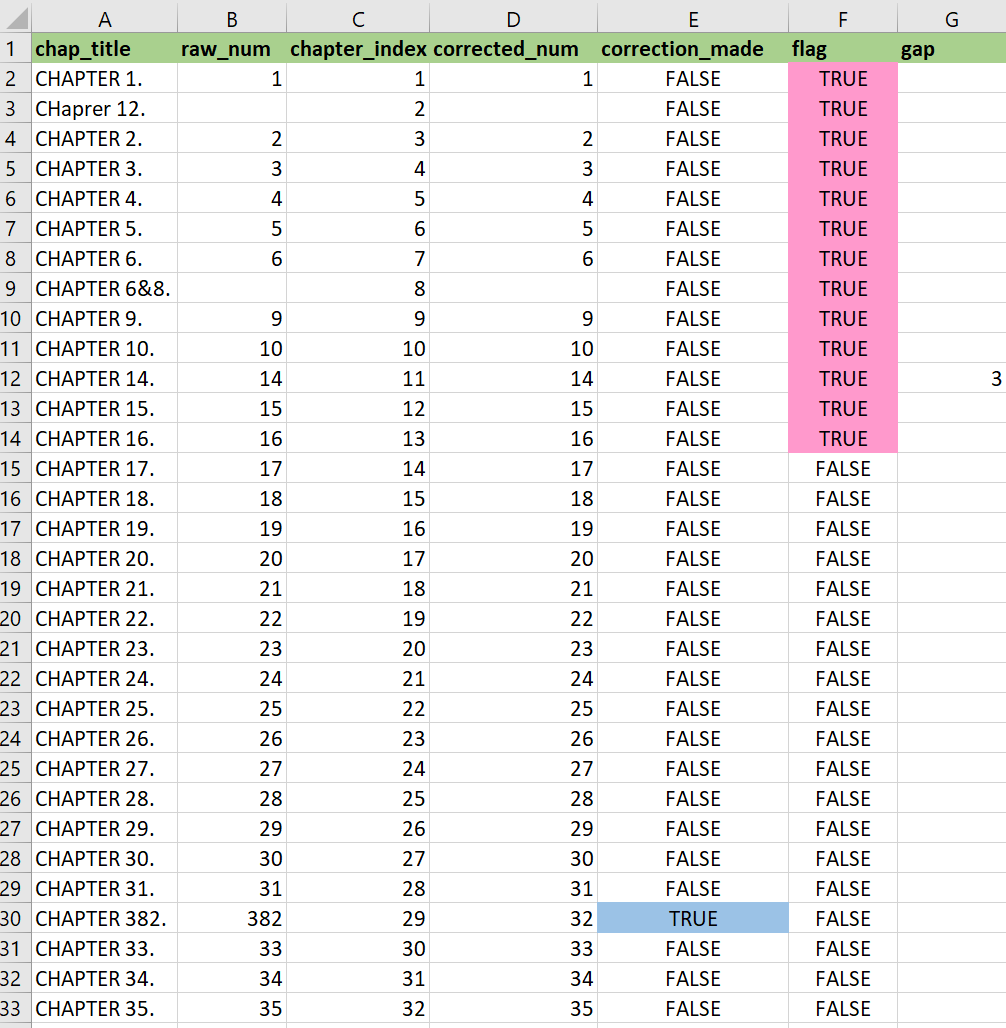

In [11]:
display(Image(filename='chap_num_manual.png', embed=True))

All "chapnumflags" files, one for each volume, were then examined by a manual reviewer. Obvious errors not caught by the above automatic process could be added by the manual reviewer using the "corrected_num" column. Rows that could either not be validated as actual chapters or which could be validated as either one chapter or another were left for a later review step. For example, while it's obvious that "CHaprer 12" below Chapter 1 is incorrect, such errors were left in place so the raw OCR output files or the image files themselves could be consulted before making a change.

**NOTE** - *While the next documented step concerns that second automated fix process (Step 4), in practice, Steps 2 and 3 were repeated before moving on to Step 4. This was intended to catch errors that might have been missed in the first run, but that were not more easily fixed in a second run because errors surrounding them had been fixed during the first run.*

### Step 4. Chapter Cleanup: Second Automatic Pass

Once all of the volume chapter fix files had been manually examined, the next round of automatic fixes could occur. This was accomplished using the next script, called **02_auto_chap_clean2.py**. The purpose of this script is twofold: 1) to integrate manual changes made to the chapter list ("chapnumflags") files in the previous step and 2) to identify chapters missed by the initial splitting process. The script generates new raw and aggregate files to reflect all changes made as well as a report file to indicate the automatic 'fixes' made by the script itself.

To begin, the fixes made in the previous two steps, represented by the "corrected_num" column of the "chapnumflags" files, needed to be integrated into the "raw" OCR output files. Recall that these files consist of word-level text rows with position, file association, and (later) chapter/section metadata.

In [12]:
# load a .csv version of the fixes file into memory. While it would be possible to use the 'output' dataframe created above,
# a file was loaded here to mimic the actual process. In practice, manual fixes made between the creation of the 'output'
# dataframe and the current step would necessitate loading the modified fix file
fix = pd.read_csv("1899_public_chapnumflags_step4.csv", encoding='utf-8', low_memory=False)
fix['gap'] = fix['gap'].replace(np.nan, '')

# Add temporary columns to the raw file so that matching can occur between rows in the raw file and rows in the fix file
# A gap column is also added to the file to enable the next automatic step
raw["fix_chap_title"] = ""
raw["raw_chap_num"] = ""
raw["cor_chap_num"] = ""
raw["chap_gap"] = ""
raw["sug_chap_title"] = raw["chapter"]
raw["sug_cor_chap_num"] = raw["cor_chap_num"]

# match manual/automatic changes from first round of manual/automatic chapter number fixes
# match corrected chapter number and gap information from the chap_num_fixes file
# to all rows in the raw file

for i in range(0, fix.shape[0]):
    idx = fix.iloc[i]["chapter_index"]
    raw.loc[((raw["chapter_index"]==idx)), ["fix_chap_title"]] = fix.iloc[i]["chap_title"]
    raw.loc[((raw["chapter_index"]==idx)), ["raw_chap_num"]] = fix.iloc[i]["raw_num"]
    raw.loc[((raw["chapter_index"]==idx)), ["cor_chap_num"]] = fix.iloc[i]["corrected_num"]
    raw.loc[((raw["chapter_index"]==idx)), ["chap_gap"]] = fix.iloc[i]["gap"]


# Clean empty cells that resulted from the previous step
raw['chap_gap'] = raw['chap_gap'].replace('', '0')
raw['chap_gap'] = raw['chap_gap'].astype(int)
raw["sug_cor_chap_num"] = raw["cor_chap_num"]
raw["sug_cor_chap_num"] = raw['sug_cor_chap_num'].replace(np.nan, '')
raw[12395:12410]

,left,top,width,height,conf,text,name,chapter,section,chapter_index,fix_chap_title,raw_chap_num,cor_chap_num,chap_gap,sug_chap_title,sug_cor_chap_num
12395,793,2227,292,35,-1,,publiclawsresolu1899nort_0096.jp2,CHaprer 1—2.,Suc. 70,3,CHaprer 12.,NaN,NaN,0,CHaprer 1—2.,
12396,793,2227,292,35,-1,,publiclawsresolu1899nort_0096.jp2,CHaprer 1—2.,Suc. 70,3,CHaprer 12.,NaN,NaN,0,CHaprer 1—2.,
12397,793,2227,239,34,94,CHAPTER,publiclawsresolu1899nort_0096.jp2,CHAPTER 2,Chapter_Title,4,CHAPTER 2.,2,2,0,CHAPTER 2,2
12398,1055,2230,30,32,94,2,publiclawsresolu1899nort_0096.jp2,CHAPTER 2,Chapter_Title,4,CHAPTER 2.,2,2,0,CHAPTER 2,2
12399,206,2310,1498,762,-1,,publiclawsresolu1899nort_0096.jp2,CHAPTER 2,Chapter_Title,4,CHAPTER 2.,2,2,0,CHAPTER 2,2
12400,206,2310,1498,762,-1,,publiclawsresolu1899nort_0096.jp2,CHAPTER 2,Chapter_Title,4,CHAPTER 2.,2,2,0,CHAPTER 2,2
12401,208,2310,1492,83,-1,,publiclawsresolu1899nort_0096.jp2,CHAPTER 2,Chapter_Title,4,CHAPTER 2.,2,2,0,CHAPTER 2,2
12402,208,2323,51,35,96,An,publiclawsresolu1899nort_0096.jp2,CHAPTER 2,Chapter_Title,4,CHAPTER 2.,2,2,0,CHAPTER 2,2
12403,276,2324,62,35,96,act,publiclawsresolu1899nort_0096.jp2,CHAPTER 2,Chapter_Title,4,CHAPTER 2.,2,2,0,CHAPTER 2,2
12404,353,2325,38,35,96,to,publiclawsresolu1899nort_0096.jp2,CHAPTER 2,Chapter_Title,4,CHAPTER 2.,2,2,0,CHAPTER 2,2


As seen above, several new columns have been added to the raw file. Three of these are derived from information in the "chapnumflags" file: 
* "fix_chap_title" - chapter title field
* "raw_chap_num" - original raw number field
* "cor_chap_num" - corrected chapter number field, as suggested by automatic and manual review

The final two added columns will be used in the upocoming automatic fix step:
* "sug_chap_title" - suggested chapter title, based on text found in chapter numbering gaps that hold missing chapters
* "sug_cor_num" - suggested chapter number, also based on text found in chapter numbering gaps that hold missing chapters

Now that we have updated our raw file with the fixes made in Steps 2 and 3, we can begin the next automatic fix process. This step is meant to identify and label missing chapters. It can be broken down as follows:
1. Create a list of all chapters preceded by numbering gaps. These are chapters that were marked using the "gap" column in the manual fix file. The numbers in this column represent the number of chapters included in the preceding gap. For example, in our example volume, no chapters were identified between chapters 10 and 14. This means that three chapters were missing: 11, 12, and 13.
2. Once all "gap chapters" have been identified and stored, we iterate through them.
3. For each gap chapter, the "text" column for the preceding chapter is parsed row-by-row (word-by-word). The purpose of this is to identify any chapter headers that were missed by the original chapter split pattern matching. This is achieved by utilizing a "looser" regex pattern than was originally permitted.
4. If a text match is found that was not previously identified as a chapter header and if that "chapter" text row is followed immediately by a number that matches one of the missing chapter numbers, all raw file rows starting at the newly identified chapter header and ending at the first chapter below it are associated with the newly identified chapter.


We'll begin with Number 1 above. Note that the only "gap" identified by this script is that between chapters 10 and 14 (as opposed to that between 6 and 9). This is due to the ambiguous chapter identified between the latter two, as explained above.

In [13]:
# Create a list to store metadata for all "gap chapters". This list will hold information about the gap as well as any proposed fixes
# The purpose of this list is to store all automatic fixes should future manual review be necessary
raw_gaps = []

# Use gap column from fix file to identify "gap chapters"
gaps_df = raw.loc[(raw["chap_gap"] >=1 ), :]
gaps_df = gaps_df[["cor_chap_num", "chap_gap"]]
gaps_df = gaps_df.drop_duplicates()
gaps_df

,cor_chap_num,chap_gap
30763,14,3


Next we iterate through all identified "gap chapters". In this case, the script only examines the gap between chapters 10 and 14. In short, the next block of code examines all rows assigned to chapter 10 in the raw file, because any text that should actually be associated with chapters 11, 12, or 13 will be located there. What do the headers of these chapters actually look like and why were they originally missed?

In [14]:
raw.loc[15760:15770, ['text', 'chapter', 'section', 'chapter_index']]

,text,chapter,section,chapter_index
15760,,CHAPTER 10,Suc. 2,11
15761,.,CHAPTER 10,Suc. 2,11
15762,CHAPTER,CHAPTER 10,Chapter_Title,11
15763,11,CHAPTER 10,Chapter_Title,11
15764,,CHAPTER 10,Chapter_Title,11
15765,,CHAPTER 10,Chapter_Title,11
15766,,CHAPTER 10,Chapter_Title,11
15767,An,CHAPTER 10,Chapter_Title,11
15768,act,CHAPTER 10,Chapter_Title,11
15769,to,CHAPTER 10,Chapter_Title,11


Recall that the original split script required that chapters be preceded by three empty spaces to be identified as a new chapter. Chapter 11 was missed because of the period that comes directly before it.

In [15]:
raw.loc[30540:30550, ['text', 'chapter', 'section', 'chapter_index']]

,text,chapter,section,chapter_index
30540,ninety-nine.,CHAPTER 10,SEc. 73,11
30541,,CHAPTER 10,SEc. 73,11
30542,,CHAPTER 10,SEc. 73,11
30543,,CHAPTER 10,SEc. 73,11
30544,,CHAPTER 10,SEc. 73,11
30545,CH,CHAPTER 10,SEc. 73,11
30546,meh,CHAPTER 10,SEc. 73,11
30547,th,CHAPTER 10,SEc. 73,11
30548,,CHAPTER 10,SEc. 73,11
30549,,CHAPTER 10,SEc. 73,11


Above is the raw text for Chapter 12's chapter header ("CH" + "meh" + "th"). It was badly garbled by OCR and thus not recognized by the original split script.

In [16]:
raw.loc[30640:30650, ['text', 'chapter', 'section', 'chapter_index']]

,text,chapter,section,chapter_index
30640,/,CHAPTER 10,Sxc. 2,11
30641,2,CHAPTER 10,Sxc. 2,11
30642,et,CHAPTER 10,Sxc. 2,11
30643,ere,CHAPTER 10,Sxc. 2,11
30644,5h,CHAPTER 10,Sxc. 2,11
30645,,CHAPTER 10,Sxc. 2,11
30646,"CHAPTER,",CHAPTER 10,Chapter_Title,11
30647,13,CHAPTER 10,Chapter_Title,11
30648,,CHAPTER 10,Chapter_Title,11
30649,,CHAPTER 10,Chapter_Title,11


As was the case with Chapter 11, Chapter 13 was missed during the initial splitting because it was not preceded by three blank text rows in the raw file. It is likely that the messy text above resulted from Chapter 12's badly garbled OCR read.

The next step involves iteration through all "gap chapters." Looser regex patterns are used to identify chapter headers that may have been missed by the original split script.

In [17]:
# DEMO: add the volume title information for inclusion in the gap fixing report to be generated from "raw_gaps" fix metadata
# lists compiled from all volumes
rawfile = "publiclawsresolu1899nort_public laws"


# Iterate through all "gap chapters"
for idx1, row in gaps_df.iterrows():
    
    # Identify chapters before and after gap
    current_chap = row['cor_chap_num']
    previous_chap = raw.iloc[idx1-1]['cor_chap_num']
    
    #Create a list of all possible chapter numbers for missing chapters within the gap
    candidate_list = []
    possible_cor_nums = [int(current_chap)-i for i in range(1,row['chap_gap']+1)]
    possible_cor_nums = list(reversed(possible_cor_nums))
    
    # Create metadata for print reporting
    gap_title = "gap: " + str(previous_chap) + "-" + str(current_chap)
    
    # Create temporary dataframe with all rows from chapter directly before gap
    prev_chap_rows = raw[raw['cor_chap_num'] == previous_chap].copy()
    
    # Create new column with text from row beneath a given row
    prev_chap_rows['shift_text'] = prev_chap_rows.text.shift(-1)

    # Create boolean variable for identifying rows whose text match a chapter regex pattern and which are followed by numeric digits
    chap_matches = prev_chap_rows[(prev_chap_rows['text'].str.match(r'[^"]*HAPTER(\.|,|:|;)*$')==True) &
                                 (prev_chap_rows['shift_text'].str.match(r'[0-9.]+(\.|,|:|;){0,2}')==True)]

    # add all potential matches, excluding chapter title of the chapter preceding the gap to a list
    # Included in this list are the potential chapter title and its starting index in the raw file
    for idx2, row in chap_matches.iterrows():
        if row['chapter'] != row['text'] +' '+ row['shift_text']:
            sug_chap_title = row['text'] +' '+ row['shift_text']
            missing_chap_start_index = idx2
            candidate_list.append({"sug_chap_title":sug_chap_title, 
                                    "missing_chap_start_index":missing_chap_start_index})


    # These conditional statements account for four possible situations: 
    # 1 potential match found, multiple missing chapters
    # multiple matches found, 1 missing chapter
    # multiple matches found, multiple missing chapters
    # 1 potential match found, 1 missing chapter
    # Chapters are only identified if the digit following the "chapter"
    # text pattern is a digit matching one of the missing chapter numbersm
    # as identified above.
    if len(candidate_list) == 1 and len(possible_cor_nums) == 1:
        candidate_list[0]["sug_cor_chap_num"] = possible_cor_nums[0]
    elif len(candidate_list) > 1 and len(possible_cor_nums) == 1:
        for i in candidate_list:
            if str(possible_cor_nums[0]) in i["sug_chap_title"]:
                i["sug_cor_chap_num"] = possible_cor_nums[0]
    elif len(candidate_list) == 1 and len(possible_cor_nums) > 1:
        for i in possible_cor_nums:
            if str(i) in candidate_list[0]["sug_chap_title"]:
                candidate_list[0]["sug_cor_chap_num"] = i
    elif len(candidate_list) > 1 and len(possible_cor_nums) > 1:
        for i in candidate_list:
            for b in possible_cor_nums:
                if str(b) in i["sug_chap_title"]:
                    i["sug_cor_chap_num"] = b

    # This iterates through all matches
    # Those with numbers that are in the missing chapters "candidate" list
    # are added to the raw dataframe via new 'suggested' chapter titles and numbers
    # being amended for all affected rows (words)
    for c in candidate_list:
        if "sug_cor_chap_num" in c:
            raw.loc[c["missing_chap_start_index"]:idx1-1, "sug_chap_title"] = c["sug_chap_title"]
            raw.loc[c["missing_chap_start_index"]:idx1-1, "sug_cor_chap_num"] = c["sug_cor_chap_num"]
            newchap_df =  raw[c["missing_chap_start_index"]:idx1]
            for q in range(0, newchap_df.shape[0]):
                if newchap_df.index.values[q] != c["missing_chap_start_index"]:
                    if newchap_df.iloc[q]['section'] != newchap_df.iloc[q-1]['section']:
                        raw.loc[c["missing_chap_start_index"]:newchap_df.index.values[q-1], "section"] = "Chapter_Title"
                        break

    # this adds various metadata concerning the gap in question to a list
    # This includes the gap's title, the missing chapter numbers, and the list of found potential matches
    # This was included for print reporting during testing, as well as to generate a total
    # fix report for the corpus so that any irregularities identified later in the process
    # could be traced to the automatic processes which may have caused them
    raw_gaps.append([gap_title, possible_cor_nums, candidate_list])

# Information for all gaps in the volume is added to a dictionary. This dictionary is used to
# create the corpus-level fix report for this stage of automatic fixes
gap_fix_dict = {'file': rawfile, 'gaplist':raw_gaps}

The gap information stored by the above script is demonstrated below. The file, "gap title," list of missing chapter numbers, as well as new chapters that were identified and implemented are listed. In our sample case, Chapters 11 & 13 were both located and added to the raw file. As in the first pass of law splitting, Chapter 12 was also missed by this script. Due to the wide variety of OCR misreads, cases like that of Chapter 12 would largely need to be fixed by manual reviewers. Chapter headers that were accidentally removed during the marginalia removal process would also need to be reviewed and fixed "by hand."

In [18]:
gap_fix_dict

{'file': 'publiclawsresolu1899nort_public laws',
 'gaplist': [['gap: 10.0-14.0',
   [11, 12, 13],
   [{'sug_chap_title': 'CHAPTER 11',
     'missing_chap_start_index': 15762,
     'sug_cor_chap_num': 11},
    {'sug_chap_title': 'CHAPTER, 13',
     'missing_chap_start_index': 30646,
     'sug_cor_chap_num': 13}]]]}

Next, a new version of the "raw" dataframe is created. This allows us to accomplish the following:
1. Extraneous columns are eliminated (i.e. those created to match rows in the raw file to those in the "chapnumflags" file)
2. The newly identified chapter titles are added to the "chapter" column by replacing the existing values with those in the "suggested" chapter title column
3. The language in the "chapter" column is standardized by replacing all values with "CHAPTER" + the most up-to-date chapter number for that particular chapter
The columns are renamed to match the original "raw" column names. Chapter indicies are regenerated to reflect newly identified chapters, and special cases (Paratextual, Chapter_Titles sections, etc.) are accounted for.

In [19]:
# Corrected number string values are converted to float values to match the decimal format of existing chapter titles
numeric_cor_nums = pd.Series(pd.to_numeric(raw["sug_cor_chap_num"], errors="coerce"))
raw["sug_cor_chap_num"] = numeric_cor_nums
raw["sug_cor_chap_num"] = raw["sug_cor_chap_num"].replace(np.nan, "")
chapters_new = "CHAPTER " + raw["sug_cor_chap_num"].astype(str)
raw['chapters_new'] = chapters_new
raw.loc[(raw["sug_cor_chap_num"]==""), ["chapters_new"]] = raw["chapter"]
adjusted_raw = pd.concat([raw["left"].copy(),
                          raw["top"].copy(),
                          raw["width"].copy(),
                          raw["height"].copy(),
                          raw["conf"].copy(),
                          raw["text"].copy(),
                          raw["name"].copy(),
                          raw["chapters_new"].copy(),
                          raw["section"].copy()], axis=1)

adjusted_raw.columns = ["left", "top", "width", "height", "conf", "text", "name", "chapter", "section"]
adjusted_raw.loc[(adjusted_raw["chapter"]=="CHAPTER "), ["chapter"]] = ""
adjusted_raw["chapter_index"] = ((adjusted_raw["chapter"].notna()) & (adjusted_raw["chapter"]!=adjusted_raw["chapter"].shift(1))).cumsum()
adjusted_raw.loc[((adjusted_raw["chapter"]=="") & (adjusted_raw["section"]=="")), ["chapter","section"]] = "Paratextual"
adjusted_raw.loc[((adjusted_raw["chapter"]!="") & (adjusted_raw["section"]=="")), ["section"]] = "Chapter_Title"
adjusted_raw.loc[((adjusted_raw["chapter"]=="") & (adjusted_raw["section"]!="")), ["chapter"]] = "Chapter_UNKNOWN"

raw = adjusted_raw

Chapters 11 & 13 have now been fully integrated into our sample raw dataframe, now represented by "adjusted_raw". Note in the second example that what little of Chapter 12's text does exist has now been assigned to Chapter 11. This is because Chapter 11 is now the next chapter above Chapter 12 (which was previously Chapter 10).

In [20]:
raw.loc[15760:15770, ['text', 'chapter', 'section', 'chapter_index']]

,text,chapter,section,chapter_index
15760,,CHAPTER 10.0,Suc. 2,11
15761,.,CHAPTER 10.0,Suc. 2,11
15762,CHAPTER,CHAPTER 11.0,Chapter_Title,12
15763,11,CHAPTER 11.0,Chapter_Title,12
15764,,CHAPTER 11.0,Chapter_Title,12
15765,,CHAPTER 11.0,Chapter_Title,12
15766,,CHAPTER 11.0,Chapter_Title,12
15767,An,CHAPTER 11.0,Chapter_Title,12
15768,act,CHAPTER 11.0,Chapter_Title,12
15769,to,CHAPTER 11.0,Chapter_Title,12


In [21]:
raw.loc[30640:30650, ['text', 'chapter', 'section', 'chapter_index']]

,text,chapter,section,chapter_index
30640,/,CHAPTER 11.0,Sxc. 2,12
30641,2,CHAPTER 11.0,Sxc. 2,12
30642,et,CHAPTER 11.0,Sxc. 2,12
30643,ere,CHAPTER 11.0,Sxc. 2,12
30644,5h,CHAPTER 11.0,Sxc. 2,12
30645,,CHAPTER 11.0,Sxc. 2,12
30646,"CHAPTER,",CHAPTER 13.0,Chapter_Title,13
30647,13,CHAPTER 13.0,Chapter_Title,13
30648,,CHAPTER 13.0,Chapter_Title,13
30649,,CHAPTER 13.0,Chapter_Title,13


Next, we generate a new version of our aggregated dataframe. While not necessary from a programmatic perspective, new aggregate .csv files were generated at this point to aid in the upcoming manual review step.

In [22]:
agg = raw[raw["text"]!=""].groupby(['chapter', 'chapter_index', 'section'], sort=False)['text'].apply(' '.join).reset_index()

At this point, **Step 2. Chapter Cleanup: First Automatic Pass was repeated** once more. Though doing so did not make a significant number of new fixes, it was necessary to generate updated "chapnumflags" files for the upcoming manual review process. These files would be used both by reviewers to identify problem areas and by the following script to generate other files associated with the manual fix process. After rerunning the first automatic fix process and generating a new found of "chap_num_fixes" files, we can move on to Step 5.

### Step 5. Chapter Cleanup: Second Manual Pass

The final step of the chapter cleanup process can be summarized as follows:
1. Generate truncated versions of the raw files including only those areas of the raw files that had been 'flagged' in the most recent round of "chap_num_fixes" files. These newly generated files are referred to as "flag_rows" files. 
2. Divide the corpus by assigning groups of volumes to individual review team members
3. Have reviewers identify problem areas using the "chap_num_fixes" files and make any necessary changes in the "flag_rows" files (excerpted areas of the raw files)
4. Have reviewers note in a standardized fashion where transcriptions would need to be made. The areas were generally those main body text that were removed during the marginalia process, as well as areas that were subject to exceptionally poor OCR performance.
5. Have reviewers transcribe missing areas at the section level to be manually inserted as new rows in the raw files.
6. Automatically re-integrate all changes made in the flag rows files into the raw files from which they were generated
7. Automatically insert newly transcribed sections to the raw files as new rows (i.e. at the word-by-word level).

To begin, it was necessary to generate the "flag_rows files in which the manual reviewers would make modifications that could be integrated back into the raw files. These were generated to make the files more navigable for the manual reviewers (the raw files themselves often contained over 1,000,000 rows). These files contained only the information relevant to the reviewers' task (text, filename, chapter, section) as well as Internet Archive links to the page image on which a given row of text is located. The purpose of thise was to make possible quick, easy references to the image files so that reviewers could be sure of any potential changes they planned to make.

The script that generated these files is called **03_gen_manual_chapfix_files.py**.

In [23]:
#DEMO - load example chapnumflags file
fix = pd.read_csv("1899_public_chapnumflags_step5.csv", encoding='utf-8', low_memory=False)

# Identify raw file rows assigned to "flagged" chapters and compile a new
# dataframe containing only these rows.
if (fix['flag']==True).any():

    raw['chapter'] = raw['chapter'].replace(np.nan, '')
    raw['section'] = raw['section'].replace(np.nan, '')
    raw['text'] = raw['text'].replace(np.nan, '')
    raw['chapter_index'] = raw['chapter_index'].replace(np.nan, '')
    raw['flag'] = False

    for i in range(0, fix.shape[0]):
        idx = fix.iloc[i]["chapter_index"]
        if fix.iloc[i]['flag']:
            raw.loc[((raw["chapter_index"]==idx)), ["flag"]] = True

    flag = raw[raw['flag']==True].copy()

    # Add IA urls to flag_rows file
    flag["vol"] = flag["name"].str.split(pat = "_")
    flag["vol"] = flag["vol"].apply(lambda x: x[0])
    flag['img_num'] = flag["name"].str.split(pat = "_")
    flag['img_num'] = flag['img_num'].apply(lambda x: x[1].replace(".jp2", ""))
    flag["jpg_url"] = "https://archive.org/download/" + flag["vol"] + "/" + flag["vol"] + "_jp2.zip/" + flag["vol"] + "_jp2%2F" + flag["name"] + "&ext=jpg"
    flag["pdf_url"] = "https://archive.org/download/" + flag["vol"] + "/" + flag["vol"] + ".pdf#page=" + flag['img_num']


    flag = flag[['text', 'name', 'chapter', 'section', 'jpg_url', 'pdf_url']]
    
    

    
# DEMO - here, the indices are added as a column in the flag row file dataframe because this is how these file were
# generated as .csv files. It was necessary to include the raw indices associated with individual rows in the 
# flag rows file because manual reviewers were asked to include the index at which a given chunk of transcribed text
# would be inserted in the coming steps
flag['rawfile_index'] = list(flag.index.values)
flag[0:10]

,text,name,chapter,section,jpg_url,pdf_url,rawfile_index
31,CHAPTER,publiclawsresolu1899nort_0073.jp2,CHAPTER 1.0,Chapter_Title,https://archive.org/download/publiclawsresolu1...,https://archive.org/download/publiclawsresolu1...,31
32,1,publiclawsresolu1899nort_0073.jp2,CHAPTER 1.0,Chapter_Title,https://archive.org/download/publiclawsresolu1...,https://archive.org/download/publiclawsresolu1...,32
33,,publiclawsresolu1899nort_0073.jp2,CHAPTER 1.0,Chapter_Title,https://archive.org/download/publiclawsresolu1...,https://archive.org/download/publiclawsresolu1...,33
34,,publiclawsresolu1899nort_0073.jp2,CHAPTER 1.0,Chapter_Title,https://archive.org/download/publiclawsresolu1...,https://archive.org/download/publiclawsresolu1...,34
35,,publiclawsresolu1899nort_0073.jp2,CHAPTER 1.0,Chapter_Title,https://archive.org/download/publiclawsresolu1...,https://archive.org/download/publiclawsresolu1...,35
36,An,publiclawsresolu1899nort_0073.jp2,CHAPTER 1.0,Chapter_Title,https://archive.org/download/publiclawsresolu1...,https://archive.org/download/publiclawsresolu1...,36
37,act,publiclawsresolu1899nort_0073.jp2,CHAPTER 1.0,Chapter_Title,https://archive.org/download/publiclawsresolu1...,https://archive.org/download/publiclawsresolu1...,37
38,to,publiclawsresolu1899nort_0073.jp2,CHAPTER 1.0,Chapter_Title,https://archive.org/download/publiclawsresolu1...,https://archive.org/download/publiclawsresolu1...,38
39,"revise,",publiclawsresolu1899nort_0073.jp2,CHAPTER 1.0,Chapter_Title,https://archive.org/download/publiclawsresolu1...,https://archive.org/download/publiclawsresolu1...,39
40,consolidate,publiclawsresolu1899nort_0073.jp2,CHAPTER 1.0,Chapter_Title,https://archive.org/download/publiclawsresolu1...,https://archive.org/download/publiclawsresolu1...,40


For each volume, a reviewer could use the chap_num_fixes file to identify problem spots. From there they could review the applicable sections of the flag row file. If something seemed easily repairable, changes would be made directly to the flag row file. For example, the chapter headers for Chapters 7 and 8 are easily identifiable to the human eye, but were not fixed in previous steps because of the ambiguous chapter identification between Chapters 6 and 9: "CHAPTER 6&8". Looking through the flag rows file, a reviewer could easily identify Chapter 7's header and then be sure that "CHAPTER 6&8" actually refers to Chapter 8. That reviewer could then make the necessary changes to the 'chapter' and 'section' columns of the flag rows file.

In [24]:
flag[14495:14505]

,text,name,chapter,section,jpg_url,pdf_url,rawfile_index
14526,,publiclawsresolu1899nort_0102.jp2,CHAPTER 6.0,Sec. 3,https://archive.org/download/publiclawsresolu1...,https://archive.org/download/publiclawsresolu1...,14526
14527,\,publiclawsresolu1899nort_0102.jp2,CHAPTER 6.0,Sec. 3,https://archive.org/download/publiclawsresolu1...,https://archive.org/download/publiclawsresolu1...,14527
14528,CHAPTER,publiclawsresolu1899nort_0102.jp2,CHAPTER 6.0,Chapter_Title,https://archive.org/download/publiclawsresolu1...,https://archive.org/download/publiclawsresolu1...,14528
14529,7,publiclawsresolu1899nort_0102.jp2,CHAPTER 6.0,Chapter_Title,https://archive.org/download/publiclawsresolu1...,https://archive.org/download/publiclawsresolu1...,14529
14530,,publiclawsresolu1899nort_0102.jp2,CHAPTER 6.0,Chapter_Title,https://archive.org/download/publiclawsresolu1...,https://archive.org/download/publiclawsresolu1...,14530
14531,,publiclawsresolu1899nort_0102.jp2,CHAPTER 6.0,Chapter_Title,https://archive.org/download/publiclawsresolu1...,https://archive.org/download/publiclawsresolu1...,14531
14532,,publiclawsresolu1899nort_0102.jp2,CHAPTER 6.0,Chapter_Title,https://archive.org/download/publiclawsresolu1...,https://archive.org/download/publiclawsresolu1...,14532
14533,An,publiclawsresolu1899nort_0102.jp2,CHAPTER 6.0,Chapter_Title,https://archive.org/download/publiclawsresolu1...,https://archive.org/download/publiclawsresolu1...,14533
14534,act,publiclawsresolu1899nort_0102.jp2,CHAPTER 6.0,Chapter_Title,https://archive.org/download/publiclawsresolu1...,https://archive.org/download/publiclawsresolu1...,14534
14535,in,publiclawsresolu1899nort_0102.jp2,CHAPTER 6.0,Chapter_Title,https://archive.org/download/publiclawsresolu1...,https://archive.org/download/publiclawsresolu1...,14535


Chapter 7's chapter header is easily identifiable above.

In [25]:
flag[14630:14640]

,text,name,chapter,section,jpg_url,pdf_url,rawfile_index
14661,nine.,publiclawsresolu1899nort_0102.jp2,CHAPTER 6.0,SEc. 8,https://archive.org/download/publiclawsresolu1...,https://archive.org/download/publiclawsresolu1...,14661
14662,,publiclawsresolu1899nort_0102.jp2,CHAPTER 6.0,SEc. 8,https://archive.org/download/publiclawsresolu1...,https://archive.org/download/publiclawsresolu1...,14662
14663,,publiclawsresolu1899nort_0102.jp2,CHAPTER 6.0,SEc. 8,https://archive.org/download/publiclawsresolu1...,https://archive.org/download/publiclawsresolu1...,14663
14664,,publiclawsresolu1899nort_0102.jp2,CHAPTER 6.0,SEc. 8,https://archive.org/download/publiclawsresolu1...,https://archive.org/download/publiclawsresolu1...,14664
14665,CHAPTER,publiclawsresolu1899nort_0102.jp2,CHAPTER 6&8.,Chapter_Title,https://archive.org/download/publiclawsresolu1...,https://archive.org/download/publiclawsresolu1...,14665
14666,6&8.,publiclawsresolu1899nort_0102.jp2,CHAPTER 6&8.,Chapter_Title,https://archive.org/download/publiclawsresolu1...,https://archive.org/download/publiclawsresolu1...,14666
14667,,publiclawsresolu1899nort_0102.jp2,CHAPTER 6&8.,Chapter_Title,https://archive.org/download/publiclawsresolu1...,https://archive.org/download/publiclawsresolu1...,14667
14668,,publiclawsresolu1899nort_0102.jp2,CHAPTER 6&8.,Chapter_Title,https://archive.org/download/publiclawsresolu1...,https://archive.org/download/publiclawsresolu1...,14668
14669,,publiclawsresolu1899nort_0102.jp2,CHAPTER 6&8.,Chapter_Title,https://archive.org/download/publiclawsresolu1...,https://archive.org/download/publiclawsresolu1...,14669
14670,An,publiclawsresolu1899nort_0102.jp2,CHAPTER 6&8.,Chapter_Title,https://archive.org/download/publiclawsresolu1...,https://archive.org/download/publiclawsresolu1...,14670


Chapter 8's header, which follows shortly after that of Chapter 7, can be seen above. Here, the reviewer would change the "chapter" value in all applicable rows to "Chapter 8.0", and the 'section' value in all applicable rows to "Chapter_Title".

For those errors that involved actual missing text, a reviewer would use a prepared log file / template to enter the transcribed text. The purpose for using this file was two-fold:
1. To allow for automatic insertion of transcribed rows into the raw files
2. To log all changes made during this manual review process (both those that require transcription and those that do not) so that any irregularities or mistakes that resulted from this round of fixes could be traced back to their source.

In [26]:
step4_fixlog = pd.read_csv("step4_fixlog.csv", encoding='utf-8', low_memory=False)

In [27]:
step4_fixlog

,Volume,Reviewer,Chapter(s),Notes,Affected image jpg url,Transcription required,transcription_index,transcription_ID,transcription_order,transcription_chapter,transcription_section,transcription_text
0,publiclawsresolu1899nort_public laws_data,Neil,1,Page header misread as chapter title. Last lin...,https://archive.org/download/publiclawsresolu1...,yes,12034.0,1.0,1.0,CHAPTER 1.0,SEC. 66.,"his right mind, or such time as he may be cons..."
1,publiclawsresolu1899nort_public laws_data,Neil,6,"OCR missed bits from chapter 6, sections 4 and 5.",https://archive.org/download/publiclawsresolu1...,yes,14494.0,2.0,1.0,CHAPTER 6.0,Sec. 4.,Sec. 4. that this act shall apply to the elect...
2,publiclawsresolu1899nort_public laws_data,Neil,6,"OCR missed bits from chapter 6, sections 4 and 5.",https://archive.org/download/publiclawsresolu1...,yes,14513.0,3.0,1.0,CHAPTER 6.0,Sec. 4.,act are hereby repealed.
3,publiclawsresolu1899nort_public laws_data,Neil,6,"OCR missed bits from chapter 6, sections 4 and 5.",https://archive.org/download/publiclawsresolu1...,yes,14514.0,4.0,1.0,CHAPTER 6.0,Sec. 5.,Sec. 5. That this act shall be in force from a...
4,publiclawsresolu1899nort_public laws_data,Neil,"7,8",Split script missed the chapter 7 chapter head...,https://archive.org/download/publiclawsresolu1...,no,NaN,NaN,NaN,NaN,NaN,NaN
5,publiclawsresolu1899nort_public laws_data,Neil,12,"Chapter 12 header misread as ""Ch"" ""meh"" ""th"" a...",https://archive.org/download/publiclawsresolu1...,no,NaN,NaN,NaN,NaN,NaN,NaN


The columns in the above log (showing only those remaining errors in our sample chapters) correspond to the following pieces of information:
* Volume - the volume currently under review
* Reviewer - the person responsible for reviewing that volume
* Chapter(s) - the chapters affected by the error in question
* Notes - reviewer's notes about the nature of the error
* Affected image jpeg url - the Internet Archive url for the relevant page images
* Transcription required - yes/no. Used by the automatic fix integration script to note which rows contain transcription text for insertion in the raw file
* transcription_index - the raw file location where the transcribed rows should be inserted
* transcription_id - key value unique to each individual row requiring transcription. This was also utilzied by the insertion script
* transcription_order - denotes the order in which transcribed sections should be inserted into the relevant gap in the raw file
* transcription_chapter - the value to be placed in the 'chapter' column for all newly inserted raw files relating to the transcription in a given log file row
* transcription_section - the value to be placed in the 'section' column for all newly inserted raw files relating to the transcription in a given log file row
* transcription_text - the transcribed text that would be added, word by word, to the raw file alongside the metadata in the above two columns of the log file

For example, consider the flag file rows displayed below. Upon close inspection one notices that the flow of the text cuts off right after "the employment of that number." It picks up again with text that does not logically flow from the  text above it. One can also see that this occurs exactly when the page transitions from image number 101 to image number 102 (see the 'name' column). As a result it can be surmised that some of the text at the top bottom of image number 101 or the top of image number 102 was removed by the marginalia removal process.

In [28]:
flag[14455:14500]

,text,name,chapter,section,jpg_url,pdf_url,rawfile_index
14486,and,publiclawsresolu1899nort_0101.jp2,CHAPTER 6.0,Sec. 3,https://archive.org/download/publiclawsresolu1...,https://archive.org/download/publiclawsresolu1...,14486
14487,each,publiclawsresolu1899nort_0101.jp2,CHAPTER 6.0,Sec. 3,https://archive.org/download/publiclawsresolu1...,https://archive.org/download/publiclawsresolu1...,14487
14488,house,publiclawsresolu1899nort_0101.jp2,CHAPTER 6.0,Sec. 3,https://archive.org/download/publiclawsresolu1...,https://archive.org/download/publiclawsresolu1...,14488
14489,authorizes,publiclawsresolu1899nort_0101.jp2,CHAPTER 6.0,Sec. 3,https://archive.org/download/publiclawsresolu1...,https://archive.org/download/publiclawsresolu1...,14489
14490,the,publiclawsresolu1899nort_0101.jp2,CHAPTER 6.0,Sec. 3,https://archive.org/download/publiclawsresolu1...,https://archive.org/download/publiclawsresolu1...,14490
14491,employment,publiclawsresolu1899nort_0101.jp2,CHAPTER 6.0,Sec. 3,https://archive.org/download/publiclawsresolu1...,https://archive.org/download/publiclawsresolu1...,14491
14492,of,publiclawsresolu1899nort_0101.jp2,CHAPTER 6.0,Sec. 3,https://archive.org/download/publiclawsresolu1...,https://archive.org/download/publiclawsresolu1...,14492
14493,that,publiclawsresolu1899nort_0101.jp2,CHAPTER 6.0,Sec. 3,https://archive.org/download/publiclawsresolu1...,https://archive.org/download/publiclawsresolu1...,14493
14494,number.,publiclawsresolu1899nort_0101.jp2,CHAPTER 6.0,Sec. 3,https://archive.org/download/publiclawsresolu1...,https://archive.org/download/publiclawsresolu1...,14494
14495,,publiclawsresolu1899nort_0102.jp2,CHAPTER 6.0,Sec. 3,https://archive.org/download/publiclawsresolu1...,https://archive.org/download/publiclawsresolu1...,14495


Comparing these rows with the image below, we notice that sections 4 and 5 of our volume's chapter 6 were both partially cut off during the marginalia removal process and partially obscured due to a poor OCR reading.

!["publiclawsresolu1899nort, Chapter 6, Sections 4-5"](https://archive.org/download/publiclawsresolu1899nort/publiclawsresolu1899nort_jp2.zip/publiclawsresolu1899nort_jp2%2Fpubliclawsresolu1899nort_0102.jp2&ext=jpg "publiclawsresolu1899nort_102.jpeg")

As a result, the reviewer would add 3 separate rows to the log file, one for each required chunk of transcription: The beginning of Section 4 that was missed as a result of the marginalia process, the end of Section 4 that was missed due to garbled OCR, and all of Section 5 that was also missed due to garbled OCR. All relevant column values would be added and the missing text would be transcribed in the appropriate column.

Once these or similar steps had been completed for every error found in every volume using the chap_num_fixes files, the following code was used to automatically integrate all changes made during this step. This was accomplished using **04_integrate_manual_chapfixes.py**. To begin, we define a separate function for adding new rows to a dataframe:

In [29]:
# define the function for inserting new rows into a dataframe
def Insert_row_(insertion_idx, joined, transcribed_rows): 
    # Slice the upper half of the dataframe
    row_number = insertion_idx+1
    df1 = joined[0:row_number] 
   
    # Store the result of lower half of the dataframe 
    df2 = joined[row_number:] 
   
    # Concat the two dataframes 
    df_result = pd.concat([df1, transcribed_rows, df2]) 
   
    # Reassign the index labels 
    df_result.index = [*range(df_result.shape[0])] 
   
    # Return the updated dataframe 
    return df_result 

For **04_integrate_manual_chapfixes.py**, three items would be required:
1. The raw file
2. The "flag_rows" file
3. The rows of the fix file related to the volume in question, separated into their own temporary data frame (see **NOTE** below)

**NOTE** - *While each volume has its own flag rows and raw files, the fix log file contains information for all volumes. As a result, only the rows of the fix log file that related to a given volume were sent to the function that performed the operations below. Separating these rows was accomplished during the step that reads in each set of files in the corpus, volume by volume. Because this example only uses volume as a sample, those pieces of code have been left out.*

In [30]:

# For the production code, each of the following variables would need to be intialized or loaded from a file.
# Because this demonstration continues from the previous steps with all variables still in memory, 
# we'll utilize the following variables instead:
# raw
# step4_fixlog

# That being said, it is necessary to load a new version of our flag rows file into memory.
# The following version of this file has undergone all of the necessary manual changes mentioned above
flag = pd.read_csv("1899_public_sample_flag_rows.csv", encoding='utf-8', low_memory=False)


# Clean the three fix and raw dataframes of blank values resulting from .csv loading process
step4_fixlog['transcription_ID'] = step4_fixlog['transcription_ID'].replace(np.nan, '')
step4_fixlog['transcription_index'] = step4_fixlog['transcription_index'].replace(np.nan, '')
raw['chapter'] = raw['chapter'].replace(np.nan, '')
raw['section'] = raw['section'].replace(np.nan, '')
raw['text'] = raw['text'].replace(np.nan, '')
raw['chapter_index'] = raw['chapter_index'].replace(np.nan, '')

# Replace blank values in the flag rows file
# Rename columns to differentiate flag_row file column values from their 
# counterpart values in the raw file
flag['text'] = flag['text'].replace(np.nan, '')
flag.columns = ["rawfile_index", "fr_text", "fr_name", "fr_chapter", "fr_section", "jpg_url", "pdf_url"]
flag.set_index('rawfile_index', inplace=True)


# Apply flag_row file changes to raw file
# This is done first by joining the flag rows to their correspoonding rows in the raw file
# All values in the original raw value columns are replaced by their flag row values
# This replaces all raw file rows with the corresponding flag rows, adding all changes
# made by the manual reviewer back into the raw file.
# All "fr" files are then deleted, returning the raw dataframe to its original shape

joined = raw.join(flag)
joined['fr_name'] = joined['fr_name'].replace(np.nan, 'NON_FLAG_ROW')
joined.loc[(joined['fr_name']!="NON_FLAG_ROW"), ["chapter"]] = joined['fr_chapter']
joined.loc[(joined['fr_name']!="NON_FLAG_ROW"), ["text"]] = joined['fr_text']
joined.loc[(joined['fr_name']!="NON_FLAG_ROW"), ["section"]] = joined['fr_section']

del joined["fr_text"]
del joined["fr_name"]
del joined["fr_chapter"]
del joined["fr_section"]
del joined["jpg_url"]
del joined["pdf_url"]


# make a list of the unique transcription IDs so groups of multiple transcribed chapters/transcriptions
# can be inserted into raw in blocks
transcriptions = [i for i in list(step4_fixlog.transcription_ID.unique()) if i != '']

# Add markers at each index that requires a transcription directly beneath it BEFORE
# any transcribed rows are added. That way the new rows can be added based on the markers
# and not based on indices that will change with each insertion.
transcription_ID_idx_pairs = step4_fixlog.loc[:, ['transcription_index', 'transcription_ID']].copy().drop_duplicates()
transcription_ID_idx_pairs = transcription_ID_idx_pairs[transcription_ID_idx_pairs['transcription_index']!='']
joined['transcription_here'] = ""
for idx, row in transcription_ID_idx_pairs.iterrows():
    insert_idx = row['transcription_index']
    joined.loc[insert_idx, ['transcription_here']] = row['transcription_ID']



# Insert transcribed text into the new version of the raw file
# this is accomplished in conjunction with the "Insert_row" function defined above.
# New raw file rows are created by splitting the values in the transcription_text column of the 
# fix log file. Image filenames are recreated from the Internet Archive links in the fix log file.
# This information, along with the section/chapter information that goes with each individual word,
# is then added to the raw dataframe in blocks using the Insert_row function.

for t in transcriptions:
    insertion_idx = joined.index[joined['transcription_here']==t][0]
    rows = []
    for i in range(0, step4_fixlog.shape[0]):
        if step4_fixlog.iloc[i]['transcription_ID']==t:

            #reconstruct image name
            vol_name = step4_fixlog.iloc[i]['Volume']
            vol_base = vol_name[:vol_name.find("_")+1]
            img_url = step4_fixlog.iloc[i]['Affected image jpg url']
            img_num=img_url[img_url.rfind("_")+1:].replace('.jp2&ext=jpg', '')
            img_name = vol_base+img_num+".jp2"

            chap = step4_fixlog.iloc[i]['transcription_chapter']
            sec = step4_fixlog.iloc[i]['transcription_section']
            text = step4_fixlog.iloc[i]['transcription_text']
            word_list = text.split()
            for word in word_list:
                rows.append({"left":"", 
                              "top":"", 
                              "width":"", 
                              "height":"", 
                              "conf":100, 
                              "text":word, 
                              "name":img_name, 
                              "chapter":chap, 
                              "section":sec, 
                              "chapter_index":"",
                              "transcription_here":""})

    transcribed_rows = pd.DataFrame(rows)

    joined = Insert_row_(insertion_idx, joined, transcribed_rows)

# reset the chapter indices following the row insertions
joined["chapter_index"] = ((joined["chapter"]!="") & ((joined["chapter"]!=joined["chapter"].shift(1)) | ((joined["section"] == "Chapter_Title") & (joined["section"]!=joined["section"].shift(1))))).cumsum()

#create new agg file (in our case, a new dataframe)
agg = joined[joined["text"]!=""].groupby(['chapter', 'section', 'chapter_index'], sort=False)['text'].apply(' '.join).reset_index()


While "joined" represents the updated raw file that was eventually output as a new .csv "raw" file by this script, here we'll set our "raw" variable equal to "joined" for the purposes of continuity.

In [31]:
raw = joined

### Chapter Cleanup Summary

With the conclusion of Step 5, the chapter split cleanup process was complete. At this point, parts of Step 2 (First Automatic Pass) were once again repeated to generate a final "chapnumflags" file for all volumes in the corpus. This enabled us to check for any remaining errors in the corpus. By checking any volumes in which chapters were "flagged" by 01_auto_chap_clean1.py, we could identify whether or not remaining errors were due to factors outside of our control. The types of errors that remained resulted from errors in the original print laws as well as in the scanned versions of said laws. Because the Internet Archive image files constitute the basic data inputs for the corpus, these types of errors were beyond our power to remedy.

As a result, a few errors remained in the corpus (missed/duplicate page scans, print typos, etc.). However, the processes described above eliminated a vast majority of the errors we identified. At the beginning of this process, we identified over 1700 errors resulting from all causes (out of ~53,000 chapters total). The above process fixed all but ~2 dozen of these errors. The remaining unresolved errors resulted from the types of issues noted above.

For example, we can look to the changes made in our example volume.

In [32]:
#Pre-fix chapter list
original_raw.chapter.drop_duplicates()

0         Paratextual
31          CHAPTER 1
12038    CHaprer 1—2.
12397       CHAPTER 2
12528       CHAPTER 3
13479       CHAPTER 4
13599       CHAPTER 5
14312       CHAPTER 6
14665    CHAPTER 6&8.
14810       CHAPTER 9
15486      CHAPTER 10
30763      CHAPTER 14
30895      CHAPTER 15
55008      CHAPTER 16
55167      CHAPTER 17
56603      CHAPTER 18
57294      CHAPTER 19
60095      CHAPTER 20
60259      CHAPTER 21
60550      CHAPTER 22
61658      CHAPTER 23
61752      CHAPTER 24
63123      CHAPTER 25
63223      CHAPTER 26
63515      CHAPTER 27
63949      CHAPTER 28
64267      CHAPTER 29
64618      CHAPTER 30
65182      CHAPTER 31
65333     CHAPTER 382
65487      CHAPTER 33
65645      CHAPTER 34
66178      CHAPTER 35
Name: chapter, dtype: object

The above chapter values were those that resulted from the original splitting process. For our sample volume, this process:
* Identified 1 chapter that was not actually a chapter: "CHaprer 1-2"
* Mis-numbered two existing chapters: Chapter 8 ("Chapter 6&8") and Chapter 32 ("Chapter 382")
* Failed to identify 4 existing chapters: Chapter 7, Chapters 11-13

In other words, in a sample with 35 actual chapters, we can identify 7 different errors. While this error percentage (20%) is unusually high for the corpus as a whole, the errors found in our sample are typical of those found elsewhere in the corpus. Looking below, we can see the progress made by the Chapter Cleanup process:

In [33]:
#Post-fix chapter list
raw.chapter.drop_duplicates()

0         Paratextual
31        CHAPTER 1.0
12412     CHAPTER 2.0
12543     CHAPTER 3.0
13494     CHAPTER 4.0
13614     CHAPTER 5.0
14327     CHAPTER 6.0
14582     CHAPTER 7.0
14719     CHAPTER 8.0
14864     CHAPTER 9.0
15540    CHAPTER 10.0
15816    CHAPTER 11.0
30599    CHAPTER 12.0
30700    CHAPTER 13.0
30817    CHAPTER 14.0
30949    CHAPTER 15.0
55062    CHAPTER 16.0
55221    CHAPTER 17.0
56657    CHAPTER 18.0
57348    CHAPTER 19.0
60149    CHAPTER 20.0
60313    CHAPTER 21.0
60604    CHAPTER 22.0
61712    CHAPTER 23.0
61806    CHAPTER 24.0
63177    CHAPTER 25.0
63277    CHAPTER 26.0
63569    CHAPTER 27.0
64003    CHAPTER 28.0
64321    CHAPTER 29.0
64672    CHAPTER 30.0
65236    CHAPTER 31.0
65387    CHAPTER 32.0
65541    CHAPTER 33.0
65699    CHAPTER 34.0
66232    CHAPTER 35.0
Name: chapter, dtype: object

### Step 6. Section Cleanup: Automatic Corrections

After the chapter cleanup was complete, we were ready to begin correcting section errors. This process involved fewer steps than the chapter cleanup process because we could reuse code written for and lessons learned from the previous step. It was understood that due to the far higher number of sections than chapters in the corpus, a thorough manual cleaning similar to that included in the chapter cleanup process would not be possible with existing resources. As a result, it was decided to focus more heavily on automatic cleaning scripts that would hopefully reduce the amount of manual effort involved. While this process corrected a large majority of the errors we were able to identify, a significant number of section-split errors were retained due to time and resource constraints.

The section cleanup process involved three steps:
1. Perform a wide range of automatic error identification/fixes using an integrated script
2. Manually fix those issues that were identified as "quick fixes"
3. Generate a final set of aggregate and raw files to reflect all of the changes of the previous steps.

For comparison purposes, here we make a copy of the `section` column of the most recent iteration of the aggregate dataframe. This will be used below to demonstrate the results of the section cleaning process.

In [34]:
agg_pre_sec_clean = agg.copy()

The first step of this process was completed using a single script, called **05_auto_section_clean.py**, to fix as many different types of errors as possible. This script performs 10 distinct operations in sequence, each of which was designed to capture a different type of error. 

*It is worth noting that the operations below are tailored closely to the needs of our specific corpus. It is likely that a different corpus would require a completely different set of automatic cleaning operations.*

Each of the cleaning operations detailed below are part of the "run_fixes" function from 05_auto_section_clean.py. This scripts functions according to the following general procedure:
1. Create a list of all raw files in the corpus, one for each volume
2. Iterate through the list and call the 'run_fixes' function for each raw file
3. For each volume / raw file:
    * Perform all of the automatic error cleanup operations and generate a new raw dataframe.
    * Compile a dictionary with information about fixes made by each operation.
    * Compile a list ("weird_chaps") of all sections of all chapters still containing sections preceded by larger than usual gaps
    * Output new post-cleanup raw & aggregate files.
4. Compile an output file with all sections of all chapters contained in the "weird_chaps" lists. This file will be used to identify "quick fixes" for manual reviewers during the following step of the section cleanup process. Print this file to .csv.
5. Compile an output file with information about fixes in this step to report on progress made by the automatic cleanup processes. Print this file to .csv.

As mentioned above, each raw file is passed to the 'run_fixes' function as an argument. The first sections of that function prepare the raw file for the cleaning operations. For this demonstration we will continue using the example 'raw' dataframe that resulted from the chapter cleanup process.

In [35]:
# Declare a counting variable to sum all fixes made to a given volume
fixes = 0

# In practice the 'raw' files had to be loaded into memory. Here we skip this step.
# raw = pd.read_csv(raw_file, encoding='utf-8', low_memory=False)

# Replace empty cell values with np.nan
raw['chapter'] = raw['chapter'].replace(np.nan, '')
raw['section'] = raw['section'].replace(np.nan, '')
raw['text'] = raw['text'].replace(np.nan, '')

#reset old chapter_index
raw["chapter_index"] = (raw.chapter != raw.chapter.shift(1)).cumsum()
raw['chapter_index'] = raw['chapter_index'].replace(np.nan, '')

# Create section indices for all rows. These indices reset to 1 with the start of each new chapter
raw["section_index"] = (raw.section != raw.section.shift(1)).groupby(raw.chapter).cumsum()

Next, we create a new dataframe containing all sections in the volume. A 'groupby' dataframe is then created to group sections by their parent chapter. Section numbers, represented by `raw_num`, are extracted from the section header string value using a series of split operations. Those sections for which a numeric `raw_num` cannot be found are assigned `np.nan` values for this column. All "Chater_Title" sections are assigned an index value of 0 so they can be treated as "numeric" in the coming steps.

In [36]:
sections = raw.loc[:, ['chapter', 'chapter_index', 'section', 'section_index']].drop_duplicates()
sections['raw_num'] = sections['section'].apply(lambda x: 0 if x == "Chapter_Title" else (x.strip().split()[1].rstrip(punctuation) if " " in x.strip() and x.strip().split()[1].rstrip(punctuation).isnumeric() else np.nan))
chapters = sections.groupby('chapter_index')

In [37]:
sections[sections['chapter_index']==8]

,chapter,chapter_index,section,section_index,raw_num
14582,CHAPTER 7.0,8,Chapter_Title,1.0,0
14626,CHAPTER 7.0,8,SEcTIon 1.,2.0,1
14661,CHAPTER 7.0,8,Skc. 2.,3.0,2
14682,CHAPTER 7.0,8,SEc. 8.,4.0,8


Once these preliminaries are complete, we can commence the cleaning operations. The following cells illustrate each of these operations.

*Note that following each operation, new section indices and section/chapter lists are generated to reflect changes made in the just-completed step. This allows us to 'stack' a series of operations in sequence so that later steps do not encounter issues that were fixed by earlier steps.*

#### Operation 1: Eliminating non-numeric section headers

Close examination of the corpus revealed that many of the identified section headers identified that did not include numbers were not actually section headers. In the following chapter (Chapter 3), the phrases "Samuel L" and "Solomon M." were identified by the original split script as being section headers. This is clearly a case of misidentification and represents well the types of errors the following operation was intended to correct.

In [38]:
sections[sections['chapter_index']==4]

,chapter,chapter_index,section,section_index,raw_num
12543,CHAPTER 3.0,4,Chapter_Title,1.0,0
12925,CHAPTER 3.0,4,Samuel L.,2.0,NaN
13010,CHAPTER 3.0,4,Solomon M.,3.0,NaN
13413,CHAPTER 3.0,4,Sec. 3.,4.0,3


If a section header was found not to include a numeric value, the section was "folded" into the first section above it that contained a numeric value. This was accomplished by assigning all rows in the misidentified section to the first numeric section header preceding it. Following each operation, new section indices and section/chapter lists are generate to reflect changes made in the just-completed step. This allows us to 'stack' a series of operations so that later steps do not encounter issues that were fixed by earlier steps.

In [39]:
# establish a counting variable for all fixes made during this step for later inclusion in the report dictionary
non_numeric = 0

# iterate through all chapters
for b in chapters.groups.keys():
    #Create a new dataframe of only those section rows belonging to a given chapter 
    chap_sects = chapters.get_group(b)

    # iterate through all sections in a chapter
    for i in range(0,chap_sects.shape[0]):

        # Determine if the raw num value for a given section is either numeric or 'Paratextual'
        has_digits = str(chap_sects.iloc[i]['raw_num']).isnumeric()
        paratextual = chap_sects.iloc[i]['section'] == "Paratextual"
        
        # If neither of these conditions are satisfied, check each nearest section above the section in question
        # to identify the nearest preceding numeric section. This accounts for situations in which multiple "non-numeric"
        # section headers occur in sequence
        if not has_digits and not paratextual:

            if i!=0:
                lag = 1
                for k in range(1,i+1):
                    if str(chap_sects.iloc[i-k]['raw_num']).isnumeric():
                        break
                    lag+=1

                # Once the nearest preceding numeric section is identified, assign all 'raw' rows in the current non-numeric section to it
                raw.loc[((raw["section_index"]==chap_sects.iloc[i]['section_index']) & (raw["chapter_index"]==chap_sects.iloc[i]['chapter_index'])), ["section"]] = chap_sects.iloc[i-lag]['section']
                
                # Add 1 to the counting variables for this operation and for the entire script
                fixes+=1
                non_numeric+=1

            else:
                continue

# Generate new section indices, raw_num values, a new sections dataframe, and a new chapters "groupby" dataframe
# to reflect changes made to the raw dataframe in the above step
raw["section_index"] = (raw.section != raw.section.shift(1)).groupby(raw.chapter).cumsum()
sections = raw.loc[:, ['chapter', 'chapter_index', 'section', 'section_index']].drop_duplicates()
sections['raw_num'] = sections['section'].apply(lambda x: 0 if x == "Chapter_Title" else (x.strip().split()[1].rstrip(punctuation) if " " in x.strip() and x.strip().split()[1].rstrip(punctuation).isnumeric() else np.nan))
sections.loc[sections["section"]=="Paratextual", "raw_num"] = 0
chapters = sections.groupby('chapter_index')

To demonstrate the results of the above step, see the examples below. In our example volume, this step eliminated 14 non-numeric sections, including the two erroneous examples noted prior to running the operation. Though a gap remains between the Chapter_Title and Section 3 in this particular chapter, later steps will attempt to identify missing sections in this and other gaps. It is for situations like this that we run a number of different operations in sequence.

In [40]:
print("Fixes made in this step:", non_numeric)
sections[sections['chapter_index']==4]

Fixes made in this step: 14


,chapter,chapter_index,section,section_index,raw_num
12543,CHAPTER 3.0,4,Chapter_Title,1.0,0
13413,CHAPTER 3.0,4,Sec. 3.,2.0,3


#### Operation 2: Eliminate references to chapters in earlier volumes

The next operation was designed to eliminate section headers that had been identified as denoting new sections in their respective chapters, but actually refer to sections in previous volumes. These patterns would often arise in laws meant to amend previous laws. The language used in such laws was often very similar to the language used to denote sections and chapters in the volume itself. As a result, many "external references" were falsely identified as belonging to the actual volume being examined. This problem was especially prevalent in the "Session Laws" volumes in the more recent years of the corpus.

In the later volumes of the corpus, it was found that while many of the actual section headers for the volume would be abbreviated ("Sec. 2", "Sec. 3", etc.), references to sections in other volumes would be spelled out in their entirety ("Section 2", "Section 3", etc.). As noted in the "Initial Splits" phase of this demonstration, however, the actual first section of each chapter would often remain unabbreviated ("Section 1").

Our example volume, published in 1899, does not use unabbreviated language like that mentioned above to reference sections from other volumes. However, a similar problem does arise in Chapter 17. In this chapter, there are two sections identified as "Section 1." Upon inspection of the actual print law (see below), however, one notices that the second "Section 1" actually refers to Section 1 of a form that is created by the law in question.

In [41]:
sections[sections['chapter_index']==18]

,chapter,chapter_index,section,section_index,raw_num
55221,CHAPTER 17.0,18,Chapter_Title,1.0,0
55266,CHAPTER 17.0,18,Section 1,2.0,1
55338,CHAPTER 17.0,18,SEcTIoN 1,3.0,1
55618,CHAPTER 17.0,18,SkEc. 2,4.0,2
56066,CHAPTER 17.0,18,Sec. 2,5.0,2
56175,CHAPTER 17.0,18,Src. 3,6.0,3
56326,CHAPTER 17.0,18,Src. 4,7.0,4
56387,CHAPTER 17.0,18,Suc. 5,8.0,5
56475,CHAPTER 17.0,18,Src. 6,9.0,6
56550,CHAPTER 17.0,18,Suc. 7,10.0,7


![1899 Public Laws, Chapter 17](https://archive.org/download/publiclawsresolu1899nort/publiclawsresolu1899nort_jp2.zip/publiclawsresolu1899nort_jp2%2Fpubliclawsresolu1899nort_0177.jp2&ext=jpg)

The following operation is designed to compensate for these types of errors and consists of two steps:
1. *Eliminate external references in the chapter title.* Iterate through the sections in a given chapter and fold all sections with headers that include unabbreviated "Section" language into the "Chapter_Title" section. Once a "Section 1" is found, that section is established as the chapter's actual first section. This would eliminate "Section 6" in the following example chapter title, which would have been originally identified as a section of the law itself.
    * Example chapter title: "An Act to Amend Section 6, Chapter 457 of the Public Local Laws of Eighteen Hundred Ninety-Seven."
2. *Eliminate external references in all sections after the chapter title.* Iterate through sections in a given chapter and fold all sections with headers that include unabbreviated "Section" language into the nearest preceding section whose header does not contain "Section" language. This would eliminate "Section 3" in the following example section, which would have been originally identified as a section of the law itself.
    * Example section: "Sec. 5. That Section 3, Chapter 245 of the Public Local Laws of Eighteen Hundred Ninety-Seven be amended as follows: etc. etc."

In [42]:
# establish a counting variable for all fixes made during this step for later inclusion in the report dictionary
external_refs = 0

# Step 1: remove all non-Section-1 "Section" splits from between Chapter_Title and the actual first section
for b in chapters.groups.keys():
    #Create a new dataframe of only those section rows belonging to a given chapter
    chap_sects = chapters.get_group(b)

     # iterate through all sections in a chapter
    for i in range(0,chap_sects.shape[0]):
        
        # determine if a given section header contains "section" language and if its raw section number equals 1
        section_full = chap_sects.iloc[i]['section'].lower().find("section") != -1
        not_one = chap_sects.iloc[i]['raw_num'] != '1'

        #If these conditions are met, assign all raw file rows for the section in question to the chapter title
        # Break after a section not meeting the above conditions is found
        if i!=0:
            if section_full and not_one:
                raw.loc[((raw["section_index"]==chap_sects.iloc[i]['section_index']) & (raw["chapter_index"]==chap_sects.iloc[i]['chapter_index'])), ["section"]] = chap_sects.iloc[0]['section']
                # Add 1 to the counting variables for this operation and for the entire script
                external_refs+=1
                fixes += 1
            else:
                break

# Generate new section indices, raw_num values, a new sections dataframe, and a new chapters "groupby" dataframe
# to reflect changes made to the raw dataframe in the above step
raw["section_index"] = (raw.section != raw.section.shift(1)).groupby(raw.chapter).cumsum()
sections = raw.loc[:, ['chapter', 'chapter_index', 'section', 'section_index']].drop_duplicates()
sections['raw_num'] = sections['section'].apply(lambda x: 0 if x == "Chapter_Title" else (x.strip().split()[1].rstrip(punctuation) if " " in x.strip() and x.strip().split()[1].rstrip(punctuation).isnumeric() else np.nan))
sections.loc[sections["section"]=="Paratextual", "raw_num"] = 0
chapters = sections.groupby('chapter_index')

# Step 2: remove all "Section" splits from between all sections following the chapter title
for b in chapters.groups.keys():
    #Create a new dataframe of only those section rows belonging to a given chapter
    chap_sects = chapters.get_group(b)

    # iterate through all sections in a chapter
    for i in range(0,chap_sects.shape[0]):
        
        
        # Identify sections with "section" language in their headers that are not in the index location where Section 1 should be
        external_ref = chap_sects.iloc[i]['section'].lower().find("section") != -1 and chap_sects.iloc[i]['section_index'] != 2   

        # If these conditions are met, find the nearest preceding section that is not an external reference.
        # If that section has "section" language but occupies position 2, it is assumed to be the actual Section 1 of the chapter
        # Otherwise, find the next section that does not have "Section" language (i.e. "Sec. 2")
        if external_ref:
            if i!=0:
                lag = 1
                for k in range(1,i+1):
                    if "section" in chap_sects.iloc[i-k]['section'].lower() and chap_sects.iloc[i-k]['section_index'] == 2:
                        break
                    elif "section" not in chap_sects.iloc[i-k]['section'].lower():
                        break
                    lag+=1
                
                # Assign all raw file rows for the current "external reference" section to the nearest valid preceding section, 
                # identified in the previous step
                raw.loc[((raw["section_index"]==chap_sects.iloc[i]['section_index']) & (raw["chapter_index"]==chap_sects.iloc[i]['chapter_index'])), ["section"]] = chap_sects.iloc[i-lag]['section']
                # Add 1 to the counting variables for this operation and for the entire script
                fixes += 1
                external_refs+=1


# Generate new section indices, raw_num values, a new sections dataframe, and a new chapters "groupby" dataframe
# to reflect changes made to the raw dataframe in the above step
raw["section_index"] = (raw.section != raw.section.shift(1)).groupby(raw.chapter).cumsum()
sections = raw.loc[:, ['chapter', 'chapter_index', 'section', 'section_index']].drop_duplicates()
sections['raw_num'] = sections['section'].apply(lambda x: 0 if x == "Chapter_Title" else (x.strip().split()[1].rstrip(punctuation) if " " in x.strip() and x.strip().split()[1].rstrip(punctuation).isnumeric() else np.nan))
sections.loc[sections["section"]=="Paratextual", "raw_num"] = 0
chapters = sections.groupby('chapter_index')

We can see now that the second "SEcTIoN 1" of Chapter 17 in our example volume has now been integrated into "Section 1", the actual first section.

In [43]:
print("Fixes made in this step:", external_refs)
sections[sections['chapter_index']==18]

Fixes made in this step: 1


,chapter,chapter_index,section,section_index,raw_num
55221,CHAPTER 17.0,18,Chapter_Title,1.0,0
55266,CHAPTER 17.0,18,Section 1,2.0,1
55618,CHAPTER 17.0,18,SkEc. 2,3.0,2
56066,CHAPTER 17.0,18,Sec. 2,4.0,2
56175,CHAPTER 17.0,18,Src. 3,5.0,3
56326,CHAPTER 17.0,18,Src. 4,6.0,4
56387,CHAPTER 17.0,18,Suc. 5,7.0,5
56475,CHAPTER 17.0,18,Src. 6,8.0,6
56550,CHAPTER 17.0,18,Suc. 7,9.0,7
56626,CHAPTER 17.0,18,Suc. 8,10.0,8


#### Operation 3: Eliminate sections whose headers include the words "south" or "September"

The next step accounts for situations in which dates or geographic coordinates were mistaken for section titles. Especially in the later volumes, one notices many instances of the words "south" and "September" followed directly by numbers. These patterns were erroneously identified by the original splitting script as denoting new sections. To fix this particular type of error, the following script identifies all sections with either the word "south" or the word "september" in its section header. Once identified, these sections are folded into the section above them in the raw file.

In [44]:
# establish a counting variable for all fixes made during this step for later inclusion in the report dictionary
south_sept_fixes = 0
# iterate through all chapters
for b in chapters.groups.keys():
    chap_sects = chapters.get_group(b)

    # iterate through all sections in a chapter
    for i in range(0,chap_sects.shape[0]):
        
        # determine if a given section header contains either "south" or "september"
        south_sept = chap_sects.iloc[i]['section'].lower().find("south") != -1 or chap_sects.iloc[i]['section'].lower().find("september") != -1

        
        # If neither of these conditions are satisfied, check each nearest section above the section in question
        # to identify the nearest section that does not satisfy these conditions. 
        # This accounts for situations in which multiple "south" or "september"
        # section headers occur in sequence
        if south_sept:
            if i!=0:
                lag = 1
                for k in range(1,i+1):
                    if "south" not in chap_sects.iloc[i-k]['section'].lower() and "september" not in chap_sects.iloc[i-k]['section'].lower():
                        break
                    lag+=1

                # Assign all raw file rows for the current "south"/"september" section to the nearest valid preceding section, 
                # identified in the previous step
                raw.loc[((raw["section_index"]==chap_sects.iloc[i]['section_index']) & (raw["chapter_index"]==chap_sects.iloc[i]['chapter_index'])), ["section"]] = chap_sects.iloc[i-lag]['section']
                
                # Add 1 to the counting variables for this operation and for the entire script
                fixes += 1
                south_sept_fixes+=1
                
            else:
                continue

# Generate new section indices, raw_num values, a new sections dataframe, and a new chapters "groupby" dataframe
# to reflect changes made to the raw dataframe in the above step
raw["section_index"] = (raw.section != raw.section.shift(1)).groupby(raw.chapter).cumsum()
sections = raw.loc[:, ['chapter', 'chapter_index', 'section', 'section_index']].drop_duplicates()
sections['raw_num'] = sections['section'].apply(lambda x: 0 if x == "Chapter_Title" else (x.strip().split()[1].rstrip(punctuation) if " " in x.strip() and x.strip().split()[1].rstrip(punctuation).isnumeric() else np.nan))
sections.loc[sections["section"]=="Paratextual", "raw_num"] = 0
chapters = sections.groupby('chapter_index')

In our particular volume, there were no such fixes to be made. In some later volumes (especially those of "Session Laws"), there were as many as 120 of this particular type of error.

#### Operations 4, 5, and 6: Fix sections numbers that have been garbled by OCR by examining the numbers of sections around them

The next three steps mimic the "lag fix" functions used in Step 2: Chapter Cleanup: First Automatic Pass. These operations examine the sections that come before and after a given section to determine whether or not the number assigned to that section is erroneous. The first operation ("lag3"), for example, checks to see if the section number three spaces after a given section is exactly 6 more than the section which comes exactly three before that section. The "lag3" operation also checks numbers 2 before and after, as well as numbers 1 before and after. The "lag2" and "lag1" operations only examine numbers within two and one spaces of a given section number, respectively. If a given section num is out of sequence but the "lag3" test returns a positive value, that section number is changed to the number that would logically appear in sequence.

Because the errors identified by the "lag3" will likely result in the fewest false positive error identifications, these are performed first. Correcting the most obvious errors first allows the script to catch errors on the fringes of areas where section number errors occur with great fequency. With fewer areas in a given problematic area, the two less conservative iterations of this operation are less likely to "fix" correct numbers that seem erroneous because the numbers around them are actually errors themselves.

That being said, it was necessary to include the "lag2" and "lag1" fix operations because certain legitimate errors would not be caught by the "lag3" operation. For example, the follow example shows sections 17-27 of Chapter 1 in our example volume. Section 23 has been misread by OCR to read as Section 238. The "lag3" operation would examine the numbers three before and three after the "238" number. However, because Section 20 is missing, the number that is three place before "238" is not equal to 6 fewer than the number that occurs three places after "238". As a result, the "lag3" operation did not fix this particular error. However, because the "lag2" operation only looks *two* places before and after a given number, it would return positive for this particular number and correct Section 238 to read as "Src. 23." instead.

In [45]:
sections[18:28]

,chapter,chapter_index,section,section_index,raw_num
3504,CHAPTER 1.0,2,Sec. 17.,18.0,17
3632,CHAPTER 1.0,2,Sec. 18.,19.0,18
3982,CHAPTER 1.0,2,Src. 19.,20.0,19
4870,CHAPTER 1.0,2,SEC. 21.,21.0,21
5019,CHAPTER 1.0,2,Sec. 22.,22.0,22
5518,CHAPTER 1.0,2,Src. 238.,23.0,238
5601,CHAPTER 1.0,2,Src. 24.,24.0,24
5855,CHAPTER 1.0,2,Src. 25.,25.0,25
5960,CHAPTER 1.0,2,Src. 26.,26.0,26
6080,CHAPTER 1.0,2,Src. 27.,27.0,27


Another example of the same phenomenon can be seen in Chapter 11 of our example script (see below). In this example, Section 13 was misread by OCR as "Src. 18." Because Sections 11 and 15 are missing, however, both the "lag3" and "lag2" operations will skip this particular error. However, because Sections 12 and 14 were correctly identified and appear in sequential order with "Src. 18", this particular section header will be changed by the "lag1" operation to read as "Sec. 13." instead. 

In [46]:
sections[120:130]

,chapter,chapter_index,section,section_index,raw_num
16900,CHAPTER 11.0,12,Src. 8.,8.0,8
17055,CHAPTER 11.0,12,SEC. 9.,9.0,9
17225,CHAPTER 11.0,12,Sec. 10.,10.0,10
17343,CHAPTER 11.0,12,SEc. 12.,11.0,12
17392,CHAPTER 11.0,12,Src. 18.,12.0,18
17444,CHAPTER 11.0,12,Src. 14.,13.0,14
17643,CHAPTER 11.0,12,SkEc. 16.,14.0,16
17847,CHAPTER 11.0,12,Src. 18.,15.0,18
17927,CHAPTER 11.0,12,Src. 19.,16.0,19
18003,CHAPTER 11.0,12,SEc. 20.,17.0,20


The code for these three operations can be seen below:

In [47]:

# lag 3 operation
# establish a counting variable for all fixes made during this step for later inclusion in the report dictionary
lag3 = 0    

# iterate through all chapters
for b in chapters.groups.keys():
    
    chap_sects = chapters.get_group(b)
    # only perform this operation on sections with more than 7 sections so the script does not 
    # attempt to examine indices that do not exist
    if chap_sects.shape[0] > 7:
        
        # iterate through all sections in a chapter except the first and last 3 sections
        for row_num in range(3,chap_sects.shape[0]-3):

            # Identify the 'raw_num' section number values for the current section and all sections
            # within three index values of it
            current_raw_num = int(chap_sects.iloc[row_num]['raw_num'])
            minus_one = int(chap_sects.iloc[row_num-1]['raw_num'])
            minus_two = int(chap_sects.iloc[row_num-2]['raw_num'])
            minus_three = int(chap_sects.iloc[row_num-3]['raw_num'])
            plus_one = int(chap_sects.iloc[row_num+1]['raw_num'])
            plus_two = int(chap_sects.iloc[row_num+2]['raw_num'])
            plus_three = int(chap_sects.iloc[row_num+3]['raw_num'])
            
            
            # Check if the current section number is not equal to the one that should logically follow the section before it
            if current_raw_num != (plus_one-1) and current_raw_num != (minus_one+1):
                
                # Examine the numbers one before and one after the section in question
                lag1_test = (plus_one-minus_one)==2
                
                # Examine the numbers two before and two after the section in question
                lag2_test = (plus_two-minus_two)==4 and plus_two-plus_one==1
                
                # Examine the numbers three before and three after the section in question
                lag3_test = (plus_three-minus_three)==6 and plus_three-plus_two==1

                # If the above tests show the surrounding numbers to maintain their sequential order, change
                # the current section's section header to reflect the correct sequential number in the raw file
                if lag1_test and lag2_test and lag3_test:
                    raw.loc[((raw["section_index"]==chap_sects.iloc[row_num]['section_index']) & (raw["chapter_index"]==chap_sects.iloc[row_num]['chapter_index'])), ["section"]] =  "Sec. " + str(minus_three+3) + "."
                    
                    # Add 1 to the counting variables for this operation and for the entire script
                    fixes+=1
                    lag3 += 1

# Generate new section indices, raw_num values, a new sections dataframe, and a new chapters "groupby" dataframe
# to reflect changes made to the raw dataframe in the above step
raw["section_index"] = (raw.section != raw.section.shift(1)).groupby(raw.chapter).cumsum()
sections = raw.loc[:, ['chapter', 'chapter_index', 'section', 'section_index']].drop_duplicates()
sections['raw_num'] = sections['section'].apply(lambda x: 0 if x == "Chapter_Title" else (x.strip().split()[1].rstrip(punctuation) if " " in x.strip() and x.strip().split()[1].rstrip(punctuation).isnumeric() else np.nan))
sections.loc[sections["section"]=="Paratextual", "raw_num"] = 0
chapters = sections.groupby('chapter_index')





# lag 2 operation
lag2 = 0
for b in chapters.groups.keys():
    chap_sects = chapters.get_group(b)
    if chap_sects.shape[0] > 5:
        for row_num in range(2,chap_sects.shape[0]-2):

            current_raw_num = int(chap_sects.iloc[row_num]['raw_num'])
            minus_one = int(chap_sects.iloc[row_num-1]['raw_num'])
            minus_two = int(chap_sects.iloc[row_num-2]['raw_num'])
            plus_one = int(chap_sects.iloc[row_num+1]['raw_num'])
            plus_two = int(chap_sects.iloc[row_num+2]['raw_num'])        

            if current_raw_num != (plus_one-1) and current_raw_num != (minus_one+1):
                lag1_test = (plus_one-minus_one)==2
                lag2_test = (plus_two-minus_two)==4 and plus_two-plus_one==1

                if lag1_test and lag2_test:
                    raw.loc[((raw["section_index"]==chap_sects.iloc[row_num]['section_index']) & (raw["chapter_index"]==chap_sects.iloc[row_num]['chapter_index'])), ["section"]] =  "Sec. " + str(minus_two+2) + "."
                    fixes+=1
                    lag2+=1

raw["section_index"] = (raw.section != raw.section.shift(1)).groupby(raw.chapter).cumsum()
sections = raw.loc[:, ['chapter', 'chapter_index', 'section', 'section_index']].drop_duplicates()
sections['raw_num'] = sections['section'].apply(lambda x: 0 if x == "Chapter_Title" else (x.strip().split()[1].rstrip(punctuation) if " " in x.strip() and x.strip().split()[1].rstrip(punctuation).isnumeric() else np.nan))
sections.loc[sections["section"]=="Paratextual", "raw_num"] = 0
chapters = sections.groupby('chapter_index')


# lag 1 operation
lag1 = 0
for b in chapters.groups.keys():
    chap_sects = chapters.get_group(b)
    if chap_sects.shape[0] > 3:
        for row_num in range(1,chap_sects.shape[0]-1):

            current_raw_num = int(chap_sects.iloc[row_num]['raw_num'])
            minus_one = int(chap_sects.iloc[row_num-1]['raw_num'])
            plus_one = int(chap_sects.iloc[row_num+1]['raw_num'])
            
            if current_raw_num != (plus_one-1) and current_raw_num != (minus_one+1):
                lag1_test = (plus_one-minus_one)==2

                if lag1_test:
                    raw.loc[((raw["section_index"]==chap_sects.iloc[row_num]['section_index']) & (raw["chapter_index"]==chap_sects.iloc[row_num]['chapter_index'])), ["section"]] =  "Sec. " + str(minus_one+1) + "."
                    fixes+=1
                    lag1+=1
                        
raw["section_index"] = (raw.section != raw.section.shift(1)).groupby(raw.chapter).cumsum()
sections = raw.loc[:, ['chapter', 'chapter_index', 'section', 'section_index']].drop_duplicates()
sections['raw_num'] = sections['section'].apply(lambda x: 0 if x == "Chapter_Title" else (x.strip().split()[1].rstrip(punctuation) if " " in x.strip() and x.strip().split()[1].rstrip(punctuation).isnumeric() else np.nan))
sections.loc[sections["section"]=="Paratextual", "raw_num"] = 0
chapters = sections.groupby('chapter_index')

The results of these operations can be seen below. Among a few other errors, Section 23 of Chapter 1 and Section 13 of Chapter 11 were both corrected with their appropriate section numbers.

In [48]:
print("Errors corrected by the 'lag3' operation:", lag3)
print("Errors corrected by the 'lag2' operation:", lag2)
print("Errors corrected by the 'lag1' operation:", lag1)

Errors corrected by the 'lag3' operation: 3
Errors corrected by the 'lag2' operation: 1
Errors corrected by the 'lag1' operation: 2


In [49]:
sections[18:28]

,chapter,chapter_index,section,section_index,raw_num
3504,CHAPTER 1.0,2,Sec. 17.,18.0,17
3632,CHAPTER 1.0,2,Sec. 18.,19.0,18
3982,CHAPTER 1.0,2,Src. 19.,20.0,19
4870,CHAPTER 1.0,2,SEC. 21.,21.0,21
5019,CHAPTER 1.0,2,Sec. 22.,22.0,22
5518,CHAPTER 1.0,2,Sec. 23.,23.0,23
5601,CHAPTER 1.0,2,Src. 24.,24.0,24
5855,CHAPTER 1.0,2,Src. 25.,25.0,25
5960,CHAPTER 1.0,2,Src. 26.,26.0,26
6080,CHAPTER 1.0,2,Src. 27.,27.0,27


In [50]:
sections[120:130]

,chapter,chapter_index,section,section_index,raw_num
16900,CHAPTER 11.0,12,Src. 8.,8.0,8
17055,CHAPTER 11.0,12,SEC. 9.,9.0,9
17225,CHAPTER 11.0,12,Sec. 10.,10.0,10
17343,CHAPTER 11.0,12,SEc. 12.,11.0,12
17392,CHAPTER 11.0,12,Sec. 13.,12.0,13
17444,CHAPTER 11.0,12,Src. 14.,13.0,14
17643,CHAPTER 11.0,12,SkEc. 16.,14.0,16
17847,CHAPTER 11.0,12,Src. 18.,15.0,18
17927,CHAPTER 11.0,12,Src. 19.,16.0,19
18003,CHAPTER 11.0,12,SEc. 20.,17.0,20


#### Operation 7: Eliminate remaining non-sequential numbers that were missed by the "lag" operations

The next four operations deal with a variety of errors that can be identified by examining the differences between the `raw_num` values of two sections. In order to identify these "gaps", sections with numbers that don't follow sequentially from the sections immediately before them, a "gap" column is added to the 'sections' dataframe at this point in the script. It is added after the preceding operations so gaps that may have originally existed but that have been fixed by this point are not included in the following operations.

In [51]:
# Convert all raw_num values to floats
sections['raw_num'] = sections['raw_num'].astype(float)
# Create a new column which holds the difference between a given column's section number (raw_num)
# and that of the section before it. This is our "gap" column
sections["gap"] = chapters.raw_num.diff(1)

Operation 7 identifies out-of-sequence section numbers that come between two consecutive sequence numbers. See the example sectioms below, taken from Chapter 1 of our example volume. A suspicious-looking "Ss 2" has been identified as new section between Sections 15 and 16, both of which seem correct. 

In [52]:
sections[10:20]

,chapter,chapter_index,section,section_index,raw_num,gap
1137,CHAPTER 1.0,2,Sec. 10.,10.0,10.0,2.0
1288,CHAPTER 1.0,2,Sec. 11.,11.0,11.0,1.0
1525,CHAPTER 1.0,2,Sec. 12.,12.0,12.0,1.0
1634,CHAPTER 1.0,2,Sec. 13.,13.0,13.0,1.0
1699,CHAPTER 1.0,2,Src. 14.,14.0,14.0,1.0
1806,CHAPTER 1.0,2,Sec. 15.,15.0,15.0,1.0
2098,CHAPTER 1.0,2,Ss 2,16.0,2.0,-13.0
2926,CHAPTER 1.0,2,Szc. 16.,17.0,16.0,14.0
3504,CHAPTER 1.0,2,Sec. 17.,18.0,17.0,1.0
3632,CHAPTER 1.0,2,Sec. 18.,19.0,18.0,1.0


It is probable that some text that was garbled by OCR resulted in a pattern identified by the original split script as a section where in fact no new section exists. Examination of the rows in the raw file below confirm this to be the case. "Ss 2" was identified as a new section because of a bad OCR reading. As a result, an erroneous "section" was inserted between the actual Sections 15 and 16 of Chapter 1.

In [53]:
raw[2090:2110]

,left,top,width,height,conf,text,name,chapter,section,chapter_index,flag,transcription_here,section_index
2090,712,533,67,31,96,my,publiclawsresolu1899nort_0077.jp2,CHAPTER 1.0,Sec. 15.,2,True,,15.0
2091,796,521,105,34,92,hand,publiclawsresolu1899nort_0077.jp2,CHAPTER 1.0,Sec. 15.,2,True,,15.0
2092,923,550,75,4,54,.---,publiclawsresolu1899nort_0077.jp2,CHAPTER 1.0,Sec. 15.,2,True,,15.0
2093,1019,521,76,41,96,day,publiclawsresolu1899nort_0077.jp2,CHAPTER 1.0,Sec. 15.,2,True,,15.0
2094,1111,520,41,33,93,of,publiclawsresolu1899nort_0077.jp2,CHAPTER 1.0,Sec. 15.,2,True,,15.0
2095,1172,547,121,5,68,------,publiclawsresolu1899nort_0077.jp2,CHAPTER 1.0,Sec. 15.,2,True,,15.0
2096,1301,521,74,37,26,TEAR,publiclawsresolu1899nort_0077.jp2,CHAPTER 1.0,Sec. 15.,2,True,,15.0
2097,1395,519,33,32,0,D),publiclawsresolu1899nort_0077.jp2,CHAPTER 1.0,Sec. 15.,2,True,,15.0
2098,1433,544,65,7,25,Ss,publiclawsresolu1899nort_0077.jp2,CHAPTER 1.0,Ss 2,2,True,,16.0
2099,1508,547,33,4,25,2,publiclawsresolu1899nort_0077.jp2,CHAPTER 1.0,Ss 2,2,True,,16.0


Below is the code for the operation designed to fix this particular type of error. In short, the script examines each section in a chapter. It identifies candidates for the aforementioned error by comparing the "gap" value of the section in question with that of the section directly following. If a given chapter is out of sequence but the chapters before and after it are consecutive with one another, the "gap" values we examine here will follow a uniform pattern. Let's look to the above example. The "gap" of "Ss 2" is -13 because 2-15 = -13. At the same time, the "gap" value of Section 16 is 14, because 16-2 = 14. The difference between these two "gap" follows a general mathematical pattern, where $a$ denotes the "gap" value of the suspicious section and $b$ denotes the "gap" value of the section directly after the suspicious section:

$ b = (a+(-2*a)+1)$

Which for our example is true:

$ 14 = ((-13)+(-2*(-13))+1)$

$ 14 = (-13)+26+1 $

The following script checks for sections where the above condition is satisfied and whose "gap" values do not equal 1 (i.e. they're correct in sequence) or 0 (i.e. they are the same as the preceding section). If these conditions are satisfied, the suspicious section is folded into the section that came before it. In many cases it is possible that a single pass of this script through all sections in a volume will leave certain instances of this error category "unfixed." As a result, this operation continues to make passes through the sections until it makes a whole pass without any new fixes being made.

In [54]:
# establish a counting variable for all fixes made during this step for later inclusion in the report dictionary
weird_inserts = 0

# establish a variable for determining whether or not a given pass made any new fixes
# Begin a while loop using this variable
run_fixes = 1
while run_fixes != 0:
    run_fixes = 0
    
    # iterate through all sections in the volume
    for r in range(0, sections.shape[0]):
        # set variables for the "gap" value of the section preceding a given section
        gap_before = sections.iloc[r-1]['gap']
        
        # set variables for the "gap" value of the section in question
        gap = sections.iloc[r]['gap']
        
        # set variables for the "gap" value of the section following a given section
        # If we've reached the last section in a chapter, we cannot check for the necessary conditions
        # So, last sections in chapters have their "gap_after" values set to 1 so that they can be skipped
        try:
            gap_after = sections.iloc[r+1]['gap']
        except:
            gap_after = 1
            
        # If a section does not have a gap of 1 or 0 and the condition described above is satisfied, fold it into the section above it
        if gap != 1 and gap != 0 and gap_before == 1 and gap_after == (gap+(-2*gap)+1):
            
            #This is accomplished by changing the 'section' value of all rows in the raw file belonging to the suspcious section
            raw.loc[((raw["section_index"]==sections.iloc[r]['section_index']) & (raw["chapter_index"]==sections.iloc[r]['chapter_index'])), ["section"]] =  sections.iloc[r-1]['section']
            
            # Add 1 to the counting variables for this operation and for the entire script
            fixes+=1
            weird_inserts+=1
            
            # add 1 to the count of fixes made during a given pass so that the while loop above will make another pass after
            # the current pass has completed
            run_fixes+=1
            
            
    # Generate new section indices, raw_num values, a new sections dataframe, and a new chapters "groupby" dataframe
    # to reflect changes made to the raw dataframe in the above step. Generate new "gap" values and reset all 'raw_num' values as floats            
    raw["section_index"] = (raw.section != raw.section.shift(1)).groupby(raw.chapter).cumsum()
    sections = raw.loc[:, ['chapter', 'chapter_index', 'section', 'section_index']].drop_duplicates()
    sections['raw_num'] = sections['section'].apply(lambda x: 0 if x == "Chapter_Title" else (x.strip().split()[1].rstrip(punctuation) if " " in x.strip() and x.strip().split()[1].rstrip(punctuation).isnumeric() else np.nan))
    sections.loc[sections["section"]=="Paratextual", "raw_num"] = 0
    sections['raw_num'] = sections['raw_num'].astype(float)
    chapters = sections.groupby('chapter_index')
    sections["gap"] = chapters.raw_num.diff(1)

Notice that the lines at the end of the above section differ from those at the end of all preceding operations. At the end of this operation, as before, we reset the `section_index` column in the raw dataframe, create a new `sections` dataframe, and generate the `raw_num` values for the new `sections` dataframe. The paratextual's `section` column value in the `sections` dataframe is set to zero, and a new `chapters` groupby dataframe is created from the regenerated `sections` dataframe. In this and all following operations, however, two further steps must be completed:
* `raw_num` column values in the `sections` dataframe must be converted to floats (so that the step below is possible)
* a new `gap` column is generated to reflect fixes made in the previous step

Compare this code with that at the end of all preceding operations to recognize the differences between the two versions.

To observe the effects of this operation, please see the rows printed below. "Ss 2" no longer appears as a row in `sections` between Sections 15 and 16

In [55]:
sections[10:20]

,chapter,chapter_index,section,section_index,raw_num,gap
1137,CHAPTER 1.0,2,Sec. 10.,10.0,10.0,2.0
1288,CHAPTER 1.0,2,Sec. 11.,11.0,11.0,1.0
1525,CHAPTER 1.0,2,Sec. 12.,12.0,12.0,1.0
1634,CHAPTER 1.0,2,Sec. 13.,13.0,13.0,1.0
1699,CHAPTER 1.0,2,Src. 14.,14.0,14.0,1.0
1806,CHAPTER 1.0,2,Sec. 15.,15.0,15.0,1.0
2926,CHAPTER 1.0,2,Szc. 16.,16.0,16.0,1.0
3504,CHAPTER 1.0,2,Sec. 17.,17.0,17.0,1.0
3632,CHAPTER 1.0,2,Sec. 18.,18.0,18.0,1.0
3982,CHAPTER 1.0,2,Src. 19.,19.0,19.0,1.0


#### Operation 8: Fixing "One-Two-Eight" Chapters

Close examination of the corpus revealed that many instances existed in which Section 3 was mistaken by OCR to read as Section 8 or Section 38. This error was often not caught by any of the above operations because Section 3 is often the final section in a chapter. In other words, there were many chapters in which the section numbering appeared as "One-Two-Eight". The following operation eliminates such errors by examining the `raw_num` and `gap` values in the chapter.

An example of this phenomenon can be seen in Chapter 7 of our example volume:

In [56]:
sections[sections['chapter_index']==8]

,chapter,chapter_index,section,section_index,raw_num,gap
14582,CHAPTER 7.0,8,Chapter_Title,1.0,0.0,NaN
14626,CHAPTER 7.0,8,SEcTIon 1.,2.0,1.0,1.0
14661,CHAPTER 7.0,8,Skc. 2.,3.0,2.0,1.0
14682,CHAPTER 7.0,8,SEc. 8.,4.0,8.0,6.0


This operation works to fix this particular category of error by identifying those section whose `gap` and `raw_num` values indicate a 3 mistaken for 8 or 38 and which follow sections with a `raw_num` value of 2. If these conditions are satisfied, the `section` values in the raw data frame for all rows in that section are changed to "Sec. 3.". As with previous operations, a new `sections` dataframe is then generated.

In [57]:
# establish a counting variable for all fixes made during this step for later inclusion in the report dictionary
one_two_eight = 0
# iterate through all sections in the volume
for r in range(0, sections.shape[0]):
    
    # Set variables for the gap/raw_num values of the current section as well as for the raw_num values of the preceding section
    num_before = sections.iloc[r-1]['raw_num']
    num = sections.iloc[r]['raw_num']
    gap = sections.iloc[r]['gap']

    # Identify whether or not the given section indicates a three mistaken for 8 or 38
    # as well as if that section is preceded by a section with a raw_num value of 2
    sec_three_as_eight = ((gap == 6 and num == 8) or (gap == 36 and num == 38)) and num_before == 2

    # If these conditions are satisfied, change the 'section' values in the raw dataframe to reflect the correct section header information
    if sec_three_as_eight:
        raw.loc[((raw["section_index"]==sections.iloc[r]['section_index']) & (raw["chapter_index"]==sections.iloc[r]['chapter_index'])), ["section"]] =  "Sec. 3."
        
        # Add 1 to the counting variables for this operation and for the entire script
        fixes+=1
        one_two_eight+=1

# Generate new section indices, raw_num values, a new sections dataframe, and a new chapters "groupby" dataframe
# to reflect changes made to the raw dataframe in the above step. Generate new "gap" values and reset all 'raw_num' values as floats 
raw["section_index"] = (raw.section != raw.section.shift(1)).groupby(raw.chapter).cumsum()
sections = raw.loc[:, ['chapter', 'chapter_index', 'section', 'section_index']].drop_duplicates()
sections['raw_num'] = sections['section'].apply(lambda x: 0 if x == "Chapter_Title" else (x.strip().split()[1].rstrip(punctuation) if " " in x.strip() and x.strip().split()[1].rstrip(punctuation).isnumeric() else np.nan))
sections.loc[sections["section"]=="Paratextual", "raw_num"] = 0
sections['raw_num'] = sections['raw_num'].astype(float)
chapters = sections.groupby('chapter_index')
sections["gap"] = chapters.raw_num.diff(1) 

As demonstrated below, the suspicious-looking "SEc. 8." at the end of Chapter 7 has been re-named "Sec. 3.":

In [58]:
sections[sections['chapter_index']==8]

,chapter,chapter_index,section,section_index,raw_num,gap
14582,CHAPTER 7.0,8,Chapter_Title,1.0,0.0,NaN
14626,CHAPTER 7.0,8,SEcTIon 1.,2.0,1.0,1.0
14661,CHAPTER 7.0,8,Skc. 2.,3.0,2.0,1.0
14682,CHAPTER 7.0,8,Sec. 3.,4.0,3.0,1.0


#### Operation 9: Fixing threes mistaken for eights in sections adjacent to 'gaps'

Because so many of the operations in this script rely on the sequence of the numbers identified in the section headers to identify problems, they often fail to identify section errors in the vicinity of missing sections. After performing all of the above operations, it was recognized that while many instances of the common problem of the number 3 being mistaken for the number 8 had been corrected by the above operations, instances of this issue that occured directly adjacent to "gaps" - that is, missing sections - remained. For example, in the rows below, we see that Section 33 was misread by OCR as Section 38. This was not corrected by the above operations because Section 32 is missing. As a result, this particular error did not satisfy the conditions in operations like the "lag" operations that would have initiated a correction.

In [59]:
sections[25:35]

,chapter,chapter_index,section,section_index,raw_num,gap
5960,CHAPTER 1.0,2,Src. 26.,25.0,26.0,1.0
6080,CHAPTER 1.0,2,Src. 27.,26.0,27.0,1.0
6145,CHAPTER 1.0,2,Src. 28.,27.0,28.0,1.0
6229,CHAPTER 1.0,2,Sec. 29.,28.0,29.0,1.0
6365,CHAPTER 1.0,2,Src. 30.,29.0,30.0,1.0
6605,CHAPTER 1.0,2,Sec. 31.,30.0,31.0,1.0
6781,CHAPTER 1.0,2,Src. 38.,31.0,38.0,7.0
6881,CHAPTER 1.0,2,Sec. 34.,32.0,34.0,-4.0
7053,CHAPTER 1.0,2,Src. 35.,33.0,35.0,1.0
7161,CHAPTER 1.0,2,Src. 37.,34.0,37.0,2.0


This operation attempts to identify and correct this type of error using the following procedures:
1. Identify sections with a `gap` value of 3 or more
2. Create a string version of the section number
3. If this string contains the number 8, create a series of new number strings in which each new occurence of the number 8 is replaced by a 3.
    * For example, a section with the number 838 would result in two new string versions, one with 338 and another with 833.
    * Note that this operation only accounts for situations in which a single 3 is mistaken for a single 8. Situations in which an 8 was added to a single 3 or in which multiple 3 digits in the same number are misread as 8 digits are *not* accounted for.
4. Create a float version of each number
5. Check for two conditions:
    * If there are missing chapters after the new number but it is sequential with the number directly before it
        * OR
    * If there are missing chapters before the new number but it is sequential with the number directly after it
6. If either of the above conditions is satisfied, change the section numbering to the current new number and adjust the raw file accordingly

In [60]:
# establish a counting variable for all fixes made during this step for later inclusion in the report dictionary
three_eight_gaps = 0

# Iterate through all sections, with the exception of the first and the last (to prevent indexing errors)
for r in range(1, sections.shape[0]-1):
    
    # Separate the section number and create a string version of it
    current_gap = sections.iloc[r]['gap']
    current_raw_num = sections.iloc[r]['raw_num']
    string_raw_num = str(int(current_raw_num))

    # initialize variables for the section numbers before and after the current section
    minus_one = sections.iloc[r-1]['raw_num']
    plus_one = sections.iloc[r+1]['raw_num']


    # Only check sections with gaps of three or greater
    if current_gap > 3:   
        
        # Iterate through all characters in the string version of the current section's 'raw_num'
        for l in range(0,len(string_raw_num)):
            
            # If one of the digits is an 8, create a new version in which that 8 is changed to a 3. Convert the new number to a float
            if string_raw_num[l] == "8":
                new_string = string_raw_num[:l] + "3" + string_raw_num[l+1:]
                new_num = float(new_string)

                # Use the new number to determine gaps / sequencing before or after the current section
                if (new_num-minus_one<=2 and new_num+1==plus_one) or (plus_one-new_num<=2 and new_num-1==minus_one):


                    # Make a correction in the raw file if the new number is found to be in sequence in one direction with a gap in the other direction
                    raw.loc[((raw["section_index"]==sections.iloc[r]['section_index']) & (raw["chapter_index"]==sections.iloc[r]['chapter_index'])), ["section"]] =  "Sec. " + new_string
                    
                    # Add 1 to the counting variables for this operation and for the entire script
                    fixes+=1
                    three_eight_gaps+=1
                    
                    # Break the loop so that no more new 8-to-3 versions of the section number are considered
                    break

                    
# Generate new section indices, raw_num values, a new sections dataframe, and a new chapters "groupby" dataframe
# to reflect changes made to the raw dataframe in the above step. Generate new "gap" values and reset all 'raw_num' values as floats
raw["section_index"] = (raw.section != raw.section.shift(1)).groupby(raw.chapter).cumsum()
sections = raw.loc[:, ['chapter', 'chapter_index', 'section', 'section_index']].drop_duplicates()
sections['raw_num'] = sections['section'].apply(lambda x: 0 if x == "Chapter_Title" else (x.strip().split()[1].rstrip(punctuation) if " " in x.strip() and x.strip().split()[1].rstrip(punctuation).isnumeric() else np.nan))
sections.loc[sections["section"]=="Paratextual", "raw_num"] = 0
sections['raw_num'] = sections['raw_num'].astype(float)
chapters = sections.groupby('chapter_index')
sections["gap"] = chapters.raw_num.diff(1)

As we can see below, the suspicious looking "Src. 38" has been changed to "Sec. 33."

In [61]:
sections[25:35]

,chapter,chapter_index,section,section_index,raw_num,gap
5960,CHAPTER 1.0,2,Src. 26.,25.0,26.0,1.0
6080,CHAPTER 1.0,2,Src. 27.,26.0,27.0,1.0
6145,CHAPTER 1.0,2,Src. 28.,27.0,28.0,1.0
6229,CHAPTER 1.0,2,Sec. 29.,28.0,29.0,1.0
6365,CHAPTER 1.0,2,Src. 30.,29.0,30.0,1.0
6605,CHAPTER 1.0,2,Sec. 31.,30.0,31.0,1.0
6781,CHAPTER 1.0,2,Sec. 33,31.0,33.0,2.0
6881,CHAPTER 1.0,2,Sec. 34.,32.0,34.0,1.0
7053,CHAPTER 1.0,2,Src. 35.,33.0,35.0,1.0
7161,CHAPTER 1.0,2,Src. 37.,34.0,37.0,2.0


#### Operation 10: Identifying missing sections

The final operation in this script attempts to identify sections that were missed by the original splitting script. This operation adopts the same structure and logic used in "Step 4. Chapter Cleanup: Second Automatic Pass". The basic idea is to identify sections preceded by gaps and then to search the section immediately before a given section for text that might indicate a missed section header. This was done by using a "looser" regex expression than was used in the original splitting process. Specifically, the original splitting script looked for patterns that began with the letter "s" and were followed by *2-3* other letters. The only change made to the regex pattern in the following script is that it allows for patterns in which the letter "s" is followed by just *1-3* other letters. It recognized that many section headers had been read by OCR simply as "Sc." rather than "Sec.", and the following operation works to identify these sections.

In the above example rows, it was noted that Section 32 of Chapter 1 in our example volume is missing. As it turns out, this particular section was missed by the original splitting script for the same issue mentioned above. Instead of "Sec. 32.", the section header was misread by OCR as "Sc. 32." and thus missed by the original splitting script:

In [62]:
raw[6641:6643]

,left,top,width,height,conf,text,name,chapter,section,chapter_index,flag,transcription_here,section_index
6641,367,736,53,33,96,Sc.,publiclawsresolu1899nort_0086.jp2,CHAPTER 1.0,Sec. 31.,2,True,,30.0
6642,447,735,79,34,95,32,publiclawsresolu1899nort_0086.jp2,CHAPTER 1.0,Sec. 31.,2,True,,30.0


A significant addition to this script in comparison with that used during Step 3 of the chapter cleanup process is that it also accounts for situations in which the string values for the numbers following potential section headers are messy. These are sections in which the string value in the cell following the cell with a "Sec." or "Sc." value in the raw file's `text` field contains not only the missed section's number, but also other values. This situation is demonstrated by Section 61 of Chapter 15 in our example volume. The section was missed by the original splitting script because the numeric value following the section header was read by OCR as "61.7Any" instead of "61."

In [63]:
raw[44771:44773]

,left,top,width,height,conf,text,name,chapter,section,chapter_index,flag,transcription_here,section_index
44771,258,2736,93,35,0,SEc.,publiclawsresolu1899nort_0157.jp2,CHAPTER 15.0,Src. 60.,16,True,,51.0
44772,373,2734,176,44,57,61.7Any,publiclawsresolu1899nort_0157.jp2,CHAPTER 15.0,Src. 60.,16,True,,51.0


In order to extract numbers from messy numeric cells like that seen above, the following function iterates through characters in `text` cells following potential "Sec." header matches. It finds the first numeric value in the field and builds a number string out of all consecutive numeric values following the initial numeric value. Once a non-numeric character is encountered, the loop breaks and the existing number string is returned in `int` form as the potential section number. Using the above example, the script would iterate through each character in "61.7Any", starting with the first numeric character encountered and ending with the next non-numeric character encountered. This process extracts the "61" from the messy string above and returns it as a potential section number.

In [64]:
# Receive the raw "text" cell string value for a cell following a potential section match
def get_nums_from_str(shift_text):
    
    #Initialize the new number string
    unbroken_num = ""
    
    # Iterate through all characters in the messy field
    for l in range(0,len(shift_text)):
        
        #add numeric values to the new number string
        if shift_text[l].isdigit():
            unbroken_num = unbroken_num + shift_text[l]
        
        # Break upon encountering a non-numeric value
        else:
            break
    # Convert the new number string to an int
    if unbroken_num != "":
        unbroken_num = int(unbroken_num)
    # Return either a null string or the new int section number
    return unbroken_num

The code for the entire process is as follows. Please consult Step 4 for more detail, as this process is a close adaptation of the code used in that step. Only gaps of sizes between 2 and 4 are examined. This is because larger gaps tend to result from numbering errors rather than actual missing sections. 

In [65]:

# establish a counting variable for all fixes made during this step for later inclusion in the report dictionary
skip_fixes = 0

# Use gap column to identify "gap sections"
gaps_df = sections.loc[((sections["gap"] >= 2) & (sections["gap"] <5)), :]

for idx1, row in gaps_df.iterrows():
    
    #Initialize variables for various metadata of the current section
    current_gap = row['gap']
    current_sec_ = row['section']
    current_sec_num = row['raw_num']
    current_sec_index = row['section_index']
    current_chapter_index = row['chapter_index']
    current_chapter = row['chapter']

    # Initiliaze variables for various metadata of the section immediately preceding the current section
    previous_sec = sections.loc[((sections["section_index"]==current_sec_index-1) & (sections["chapter_index"]==current_chapter_index)), :].reset_index()['section'][0]
    previous_sec_num = sections.loc[((sections["section_index"]==current_sec_index-1) & (sections["chapter_index"]==current_chapter_index)), :].reset_index()['raw_num'][0]
    previous_sec_index = current_sec_index-1

    #Create a list of all possible section numbers for missing sections within the gap
    candidate_list = []
    possible_cor_nums = [int(current_sec_num)-i for i in range(1,int(current_gap))]
    possible_cor_nums = list(reversed(possible_cor_nums))
    
    # Create metadata for print reporting
    gap_title = "gap: " + str(previous_sec_num) + "-" + str(current_sec_num)


    # Create temporary dataframe with all rows from section directly before gap
    prev_sec_rows = raw.loc[((raw["section_index"]==previous_sec_index) & (raw["chapter_index"]==current_chapter_index)), :].copy()
    # Create new column in the above dataframe with text from row following each row
    prev_sec_rows['shift_text'] = prev_sec_rows.text.shift(-1)

    # Create boolean variable for identifying rows with text matching a section regex pattern 
    # and which are followed by cells containing numeric digits
    sec_matches = prev_sec_rows[(prev_sec_rows['text'].str.match(r'(S|s)[a-zA-Z]{1,3}(\.|,|:|;){0,2}$')==True) &
                                 (prev_sec_rows['shift_text'].str.match(r'[0-9.]+(\.|,|:|;){0,2}')==True)]

    # add all potential matches (excluding section title of the preceding section) to a list
    # Included in this list are the potential section title and its starting index in the raw file
    for idx2, row in  sec_matches.iterrows():
        if previous_sec != row['text'] +' '+ row['shift_text']:
            
            # Use the function declared above to extract number values from both clean and messy cells
            num = get_nums_from_str(row['shift_text'])
            
            # If the extracted number matches one of the missing sections, add the potential section information it to the candidate list
            # This includes a constructed section header and a start index
            if num in possible_cor_nums:
                sug_sec_title = row['text'] +' '+ str(num) + '.'
                missing_sec_start_index = idx2
                candidate_list.append({"sug_sec_title":sug_sec_title, 
                                    "missing_sec_start_index":missing_sec_start_index})


    # These conditional statements account for four possible situations: 
    # 1 potential match found, multiple missing sections
    # multiple matches found, 1 missing section
    # multiple matches found, multiple missing sections
    # 1 potential match found, 1 missing section
    #
    # Sections are only identified if the digit following the "Sec.", "Sc.", etc.
    # text pattern is a digit matching one of the missing section numbers,
    # as identified above. Those sections whose newly constructed headers
    # contain missing section numbers are added to a list to be 
    # integrated into the raw file
    if len(candidate_list) == 1 and len(possible_cor_nums) == 1:
        candidate_list[0]["sug_cor_sec_num"] = possible_cor_nums[0]

    elif len(candidate_list) > 1 and len(possible_cor_nums) == 1:
        for i in candidate_list:
            if str(possible_cor_nums[0]) in i["sug_sec_title"]:
                i["sug_cor_sec_num"] = possible_cor_nums[0]

    elif len(candidate_list) == 1 and len(possible_cor_nums) > 1:
        for i in possible_cor_nums:
            if str(i) in candidate_list[0]["sug_sec_title"]:
                candidate_list[0]["sug_cor_sec_num"] = i

    elif len(candidate_list) > 1 and len(possible_cor_nums) > 1:
        for i in candidate_list:
            for b in possible_cor_nums:
                if str(b) in i["sug_sec_title"]:
                    i["sug_cor_sec_num"] = b

                    
    # Iterate through all potential matches. Add those to the raw file whose headers contained
    # Numbers known to belong to missing sections. This is accomplished using the index information
    # store dwith each potential match.
    for c in candidate_list:
        if "sug_cor_sec_num" in c:
            raw.loc[c["missing_sec_start_index"]:idx1-1, "section"] = c["sug_sec_title"]
            raw.loc[c["missing_sec_start_index"]:idx1-1, "raw_num"] = c["sug_cor_sec_num"]
            
            # Add 1 to the counting variables for this operation and for the entire script
            skip_fixes+=1
            fixes+=1

# Generate new section indices, raw_num values, a new sections dataframe, and a new chapters "groupby" dataframe
# to reflect changes made to the raw dataframe in the above step. Generate new "gap" values and reset all 'raw_num' values as floats
raw["section_index"] = (raw.section != raw.section.shift(1)).groupby(raw.chapter).cumsum()
sections = raw.loc[:, ['chapter', 'chapter_index', 'section', 'section_index']].drop_duplicates()
sections['raw_num'] = sections['section'].apply(lambda x: 0 if x == "Chapter_Title" else (x.strip().split()[1].rstrip(punctuation) if " " in x.strip() and x.strip().split()[1].rstrip(punctuation).isnumeric() else np.nan))
sections.loc[sections["section"]=="Paratextual", "raw_num"] = 0
sections['raw_num'] = sections['raw_num'].astype(float)
chapters = sections.groupby('chapter_index')
sections["gap"] = chapters.raw_num.diff(1)

To reference the examples mentioned above, both situations in which the "Sec." language of a section header was misread (i.e. "Sc.") and situations in which a section number was garbled (i.e. "61.7Any") are accounted for by the aobve script. The following rows show the regions in which new `section` values have been added to the raw file:

In [66]:
raw[6630:6650]

,left,top,width,height,conf,text,name,chapter,section,chapter_index,flag,transcription_here,section_index,raw_num
6630,217,679,42,33,96,,publiclawsresolu1899nort_0086.jp2,CHAPTER 1.0,Sec. 31.,2,True,,31.0,NaN
6631,274,689,77,32,96,of,publiclawsresolu1899nort_0086.jp2,CHAPTER 1.0,Sec. 31.,2,True,,31.0,NaN
6632,368,679,42,33,96,any,publiclawsresolu1899nort_0086.jp2,CHAPTER 1.0,Sec. 31.,2,True,,31.0,NaN
6633,426,679,68,33,96,of,publiclawsresolu1899nort_0086.jp2,CHAPTER 1.0,Sec. 31.,2,True,,31.0,NaN
6634,510,677,215,43,96,the,publiclawsresolu1899nort_0086.jp2,CHAPTER 1.0,Sec. 31.,2,True,,31.0,NaN
6635,741,677,41,33,96,provisions,publiclawsresolu1899nort_0086.jp2,CHAPTER 1.0,Sec. 31.,2,True,,31.0,NaN
6636,797,677,79,33,96,of,publiclawsresolu1899nort_0086.jp2,CHAPTER 1.0,Sec. 31.,2,True,,31.0,NaN
6637,892,676,172,42,96,this,publiclawsresolu1899nort_0086.jp2,CHAPTER 1.0,Sec. 31.,2,True,,31.0,NaN
6638,215,733,1459,613,-1,chapter.,publiclawsresolu1899nort_0086.jp2,CHAPTER 1.0,Sec. 31.,2,True,,31.0,NaN
6639,261,733,1413,44,-1,,publiclawsresolu1899nort_0086.jp2,CHAPTER 1.0,Sec. 31.,2,True,,31.0,NaN


In [67]:
raw[44761:44781]

,left,top,width,height,conf,text,name,chapter,section,chapter_index,flag,transcription_here,section_index,raw_num
44761,808,2676,65,34,96,his,publiclawsresolu1899nort_0157.jp2,CHAPTER 15.0,Src. 60.,16,True,,60.0,NaN
44762,889,2676,131,43,96,rights,publiclawsresolu1899nort_0157.jp2,CHAPTER 15.0,Src. 60.,16,True,,60.0,NaN
44763,1036,2677,43,33,96,to,publiclawsresolu1899nort_0157.jp2,CHAPTER 15.0,Src. 60.,16,True,,60.0,NaN
44764,1096,2686,25,24,96,a,publiclawsresolu1899nort_0157.jp2,CHAPTER 15.0,Src. 60.,16,True,,60.0,NaN
44765,1138,2676,102,34,96,deed,publiclawsresolu1899nort_0157.jp2,CHAPTER 15.0,Src. 60.,16,True,,60.0,NaN
44766,1258,2676,62,34,96,for,publiclawsresolu1899nort_0157.jp2,CHAPTER 15.0,Src. 60.,16,True,,60.0,NaN
44767,1336,2676,88,34,96,said,publiclawsresolu1899nort_0157.jp2,CHAPTER 15.0,Src. 60.,16,True,,60.0,NaN
44768,1442,2676,107,34,96,land.,publiclawsresolu1899nort_0157.jp2,CHAPTER 15.0,Src. 60.,16,True,,60.0,NaN
44769,214,2733,1461,102,-1,,publiclawsresolu1899nort_0157.jp2,CHAPTER 15.0,Src. 60.,16,True,,60.0,NaN
44770,258,2733,1415,45,-1,,publiclawsresolu1899nort_0157.jp2,CHAPTER 15.0,Src. 60.,16,True,,60.0,NaN


Chapter 1, Section 32 and Chapter 15, Section 61 from our example volume are now included in the `sections` dataframe.

In [68]:
sections[25:35]

,chapter,chapter_index,section,section_index,raw_num,gap
5855,CHAPTER 1.0,2,Src. 25.,25.0,25.0,1.0
5960,CHAPTER 1.0,2,Src. 26.,26.0,26.0,1.0
6080,CHAPTER 1.0,2,Src. 27.,27.0,27.0,1.0
6145,CHAPTER 1.0,2,Src. 28.,28.0,28.0,1.0
6229,CHAPTER 1.0,2,Sec. 29.,29.0,29.0,1.0
6365,CHAPTER 1.0,2,Src. 30.,30.0,30.0,1.0
6605,CHAPTER 1.0,2,Sec. 31.,31.0,31.0,1.0
6641,CHAPTER 1.0,2,Sc. 32.,32.0,32.0,1.0
6781,CHAPTER 1.0,2,Sec. 33,33.0,33.0,1.0
6881,CHAPTER 1.0,2,Sec. 34.,34.0,34.0,1.0


In [69]:
sections[252:262]

,chapter,chapter_index,section,section_index,raw_num,gap
43706,CHAPTER 15.0,16,SEc. 56.,56.0,56.0,1.0
43783,CHAPTER 15.0,16,Src. 57.,57.0,57.0,1.0
44217,CHAPTER 15.0,16,Sec. 58.,58.0,58.0,1.0
44300,CHAPTER 15.0,16,Src. 59.,59.0,59.0,1.0
44602,CHAPTER 15.0,16,Src. 60.,60.0,60.0,1.0
44771,CHAPTER 15.0,16,SEc. 61.,61.0,61.0,1.0
44815,CHAPTER 15.0,16,SEc. 62.,62.0,62.0,1.0
44854,CHAPTER 15.0,16,SEc. 63.,63.0,63.0,1.0
45210,CHAPTER 15.0,16,Src. 64.,64.0,64.0,1.0
45366,CHAPTER 15.0,16,Sc. 65.,65.0,65.0,1.0


### Step 7. Section Cleanup: Manual Corrections

#### Generating the Output Files

With the conclusion of Operation 10 above, we have completed the automatic section cleaning process. The following step consists of a final round of manual review. Before we completing that step, it was necessary to generate a number of output files that would aid manual reviewers in their task. This was also accomplished using **05_auto_section_cleaning.py**. 

The first of these files were new raw and aggregate files:

In [70]:
#create new agg file
agg = raw[raw["text"]!=""].groupby(['chapter', 'chapter_index', 'section', 'section_index'], sort=False)['text'].apply(' '.join).reset_index()

#output new raw/agg to file
# raw.to_csv(raw_outname, index=False, encoding="utf-8")
# agg.to_csv(agg_outname, index=False, encoding="utf-8")

Next, we compile the reporting information gathered during each operation along with statistics concerning the volume as a whole into a dictionary (`report_row`) to be returned and added to a master dataframe for the entire corpus. Each volume corresponds to a single row of the resulting "master section fixes" file that is created from this dataframe. Each of these rows contains the following information:
1. Volume title
2. Total identified sections in volume
3. Total errors identified
4. Total fixes made
5. Percent of total errors fixed
6. Errors remaining
7. Fixes made during each individual operation

At the same time, a list of chapters containing sections with `gap` values greater than 3, less than one, or equal to 0 (for non Chapter_Title sections) is compiled. These chapters are of special importance because gaps that satisfy the aforementioned conditions are those that usually involve errors different from simply missingsections. Because the correction of errors involving missing sections often includes consultation of the original image files as well as actual transcription, correcting these errors requires more manual effort than other types of errors. This "weird_chaps" list is an attempt to compile all chapters containing other types of section errors that are easier to fix (garbled OCR, print typos, etc.). 

When a section containing a `gap` value that satisfies the above conditions is encountered, all rows from `sections` that correspond to that section's chapter are added to a list (`weird_chaps`). The resulting list holds all sections for all chapters within a single volume that contain these strange section gaps. The `weird_chaps` lists are added to the dictionary above so that they can be extracted later and compiled into a master `weird_chaps` file for the entire corpus. As such, the final two values in `report_row` relate to this information:

8. A list containing *all* sections, one row for each, in the chapters containing sections with strange gaps

The code for building these report dictionaries is below:

In [71]:

# Build a list of all remaining gap sizes (i.e. 0, -1, 2, 3, 56, etc.)
gaps_remaining = sections['gap'].value_counts().keys().tolist()

# Build a list of counts for each gap size in the above list
gap_counts = sections['gap'].value_counts().tolist()

# Initialize variables for counting gaps of 2 and 3 verses all other types of gaps.
# These two categories are separated from other gaps because gaps of 2 and 3 sections are most likely
# to indicate actual missing sections as opposed to simple numbering errors
two_gaps_left = 0
three_gaps_left = 0
other_gaps_left = 0

for i in range(0, len(gaps_remaining)):
    if gaps_remaining[i] == 2:
        two_gaps_left = gap_counts[i]
    elif gaps_remaining[i] == 3:
        three_gaps_left = gap_counts[i]
    elif gaps_remaining[i] != 1:
        other_gaps_left += gap_counts[i]


# Count total existing sections and add those sections that are most likely to actually be missing
total_sections = sections.shape[0]+two_gaps_left+(2*three_gaps_left)

# Calculate total errors using fixes made and remaining gaps
total_errors = fixes+two_gaps_left+(2*three_gaps_left)+other_gaps_left

# Calculate percentage of errors fixed
if total_errors>0:
    percent_fixed = round((fixes/total_errors)*100, 2)
else:
     percent_fixed = 100.00

# Calculate total remaining errors using gap information
errors_remaining = two_gaps_left+(2*three_gaps_left)+other_gaps_left

# Extract volume name from the original raw_file path
#     vol = os.path.basename(raw_file).replace("_data_cleaned_new.csv", "")

#DEMO: set volume name
vol = "publiclawsresolu1899nort_public laws"

# Find all chapters containing sections with gaps greater than 3, less than one, or equal to 0 (for sections that are not part of a Chapter_Title)
# Add each section in the chapter to a master 'weird_chaps' list for the volume
weird_chaps = []
for b in chapters.groups.keys():
        chap_sects = chapters.get_group(b)
        for r in range(0,chap_sects.shape[0]):
            if chap_sects.iloc[r]['gap'] > 3 or chap_sects.iloc[r]['gap'] < 1 or (chap_sects.iloc[r]['gap']==0 and chap_sects.iloc[r]['section_index']!=1):
                for b in range(0,chap_sects.shape[0]):
                    weird_chaps.append({"vol":vol, 
                                             "ch_index":chap_sects.iloc[b]['chapter_index'], 
                                             "ch_title":chap_sects.iloc[b]['chapter'],
                                             "sec_index":chap_sects.iloc[b]['section_index'],
                                             "sec_title":chap_sects.iloc[b]['section'],
                                             "gap":chap_sects.iloc[b]['gap']})
                break


# Compile the report dictionary for the volume in question
report_row = {"vol":vol,
              "total_sections":total_sections,
              "total_errors":total_errors,
              "total_fixes":fixes,
              "percent_fixed":percent_fixed,
              "errors_remaining":errors_remaining,
              "non_numeric":non_numeric,
              "external_refs":external_refs,
              "south_sept":south_sept_fixes,
              "lag3":lag3,
              "lag2":lag2,
              "lag1":lag1,
              "weird_inserts":weird_inserts,
              "one_two_eight":one_two_eight,
              "three_eight_gaps":three_eight_gaps,
              "skip_fixes":skip_fixes,
              "weird_chaps_list": weird_chaps}

# When part of a serialized script that runs the above operations for the entire corpus, this report row is returned to be compiled in to a
# master list for the entire corpus
# return report_row

To summarize, the manual reviewers are left with 4 types of output files:
1. New raw files reflecting all section error corrections made in this script
2. New aggrgate files reflecting all section error corrections made in this script
3. An automatic fix report file reflecting the performance of each operation for each volume, as well as more general information about the volume (total fixes, total errors remaining ,etc.)
4. A "weird_chaps" file for the entire corpus containing all sections for all chapters that contain sections with strange gap values

Before examine the final round of manual reviews, it is worth asking - how did well did our automatic operations perform? The number of corrections made in each operation can be seen below. For this particular example volume, eliminating non numeric section headers (Operation 1) and locating missing sections (Operation 10) were the most effective. However, in practice, the effectiveness of individual operations varied widely across the corpus.

In [72]:
print("Total Fixes:", fixes)
print("Operation 1:", non_numeric)
print("Operation 2:", external_refs)
print("Operation 3:", south_sept_fixes)
print("Operation 4:", lag3)
print("Operation 5:", lag2)
print("Operation 6:", lag1)
print("Operation 7:", weird_inserts)
print("Operation 8:", one_two_eight)
print("Operation 9:", three_eight_gaps)
print("Operation 10:", skip_fixes)

Total Fixes: 56
Operation 1: 14
Operation 2: 1
Operation 3: 0
Operation 4: 3
Operation 5: 1
Operation 6: 2
Operation 7: 1
Operation 8: 1
Operation 9: 1
Operation 10: 32


It is also worth noting that the automatic section cleaning process was by no means error-free. Certain "fixes" that were made ended up causing more problems. For example, by eliminating sections with "section" language that were not Section 1 of a given chapter, we intended to remove section headers that actually indicated sections from other volumes to be amended (Operation 2). However, there were many earlier volumes with chapters in which the section numbering restarts mid-chapter. A new "Section 1" is declared that relates to some new subdivision of the chapter. Unfortunately, Operation 2 ended up folding these valid "Section 1" sections into the sections above them.

While these and similar erroneous fixes resulted from various parts of the automatic section cleaning process, the final manual review step enabled us to catch most of them. To refer back to the "Section 1" example above, it was easy to recognize when a chapter's section numbering re-started mid chapter, but with "Sec. 2." rather than "Section 1". These and other problems that were not caught by the above operations were addressed by the manual process detailed below.

#### The Manual Section Cleaning Process

In addition to correcting a large number of section split errors, the above operations also generated the files to be used by manual reviewers in the coming step. In contrast to the myriad of volume-specific files involved in the manual chapter error correction process, the manual section cleanup process only involved two types of files: the 'raw' files for affected volumes and a corpus-level 'weird_chaps' file. As mentioned above, the 'weird_chaps' file consists of rows for all sections in all chapters throughout the corpus containing sections with strange 'gap' values. By 'strange,' we refer to gaps likely to indicate problems other than missing sections. These are gap values that are unusually large (greater than 3), negative, or, for sections that aren't paratextuals or chapter titles, zero. Other valid gaps (those of 2 and 3) were not included because they likely indicate actual missing chapters. These errors often involve transcription and thus require more manual effort to correct than was possible at this point in the project.

Let us examine a sample selection from the 'weird_chaps' file that relates to our example volume:

In [73]:
weird_chaps_ex = pd.read_csv("1899_public_weird_chaps_example.csv", encoding='utf-8')
weird_chaps_ex

,vol,ch_index,ch_title,sec_index,sec_title,gap
0,publiclawsresolu1899nort_public laws,18,CHAPTER 17.0,1,Chapter_Title,NaN
1,publiclawsresolu1899nort_public laws,18,CHAPTER 17.0,2,Section 1.,1.0
2,publiclawsresolu1899nort_public laws,18,CHAPTER 17.0,3,SkEc. 2.,1.0
3,publiclawsresolu1899nort_public laws,18,CHAPTER 17.0,4,Sec. 2.,0.0
4,publiclawsresolu1899nort_public laws,18,CHAPTER 17.0,5,Src. 3.,1.0
5,publiclawsresolu1899nort_public laws,18,CHAPTER 17.0,6,Src. 4.,1.0
6,publiclawsresolu1899nort_public laws,18,CHAPTER 17.0,7,Suc. 5.,1.0
7,publiclawsresolu1899nort_public laws,18,CHAPTER 17.0,8,Src. 6.,1.0
8,publiclawsresolu1899nort_public laws,18,CHAPTER 17.0,9,Suc. 7.,1.0
9,publiclawsresolu1899nort_public laws,18,CHAPTER 17.0,10,Suc. 8.,1.0


From the above example we can see that this particular chapter, Chapter 17, has two sections identified as Section 2 ("SkEc. 2." & "Sec. 2."). While it is possible that this error reflects a typo in the actual print law, such errors are less likely than the various types of computer-generated errors mentioned above. 

Let us examine the raw file rows corresponding to the beginning of each "section". Is it possible to identify an obvious error?

In [74]:
# The following rows correspond to the first lines of "SkEc. 2."
raw[55615:55635]

,left,top,width,height,conf,text,name,chapter,section,chapter_index,flag,transcription_here,section_index,raw_num
55615,624,2259,80,4,64,#NAME?,publiclawsresolu1899nort_0177.jp2,CHAPTER 17.0,Section 1,18,False,,2.0,NaN
55616,208,2287,1461,503,-1,,publiclawsresolu1899nort_0177.jp2,CHAPTER 17.0,Section 1,18,False,,2.0,NaN
55617,255,2287,1413,43,-1,,publiclawsresolu1899nort_0177.jp2,CHAPTER 17.0,Section 1,18,False,,2.0,NaN
55618,255,2287,94,34,32,SkEc.,publiclawsresolu1899nort_0177.jp2,CHAPTER 17.0,SkEc. 2,18,False,,3.0,NaN
55619,370,2288,30,31,96,2,publiclawsresolu1899nort_0177.jp2,CHAPTER 17.0,SkEc. 2,18,False,,3.0,NaN
55620,430,2287,94,34,96,And,publiclawsresolu1899nort_0177.jp2,CHAPTER 17.0,SkEc. 2,18,False,,3.0,NaN
55621,540,2288,44,33,96,to,publiclawsresolu1899nort_0177.jp2,CHAPTER 17.0,SkEc. 2,18,False,,3.0,NaN
55622,601,2287,159,34,96,further,publiclawsresolu1899nort_0177.jp2,CHAPTER 17.0,SkEc. 2,18,False,,3.0,NaN
55623,773,2297,137,24,96,secure,publiclawsresolu1899nort_0177.jp2,CHAPTER 17.0,SkEc. 2,18,False,,3.0,NaN
55624,923,2288,198,42,95,payment,publiclawsresolu1899nort_0177.jp2,CHAPTER 17.0,SkEc. 2,18,False,,3.0,NaN


In [75]:
# The following rows correspond to the first lines of "Sec. 2."
raw[56065:56085]

,left,top,width,height,conf,text,name,chapter,section,chapter_index,flag,transcription_here,section_index,raw_num
56065,246,2343,1414,50,-1,,publiclawsresolu1899nort_0178.jp2,CHAPTER 17.0,SkEc. 2,18,False,,3.0,NaN
56066,246,2344,94,43,12,Sec.,publiclawsresolu1899nort_0178.jp2,CHAPTER 17.0,Sec. 2,18,False,,4.0,NaN
56067,361,2344,31,33,96,2,publiclawsresolu1899nort_0178.jp2,CHAPTER 17.0,Sec. 2,18,False,,4.0,NaN
56068,422,2343,111,34,95,That,publiclawsresolu1899nort_0178.jp2,CHAPTER 17.0,Sec. 2,18,False,,4.0,NaN
56069,548,2343,73,34,95,the,publiclawsresolu1899nort_0178.jp2,CHAPTER 17.0,Sec. 2,18,False,,4.0,NaN
56070,637,2344,82,33,95,fees,publiclawsresolu1899nort_0178.jp2,CHAPTER 17.0,Sec. 2,18,False,,4.0,NaN
56071,744,2344,63,34,96,for,publiclawsresolu1899nort_0178.jp2,CHAPTER 17.0,Sec. 2,18,False,,4.0,NaN
56072,823,2344,71,35,96,the,publiclawsresolu1899nort_0178.jp2,CHAPTER 17.0,Sec. 2,18,False,,4.0,NaN
56073,919,2345,173,42,96,probate,publiclawsresolu1899nort_0178.jp2,CHAPTER 17.0,Sec. 2,18,False,,4.0,NaN
56074,1116,2345,92,34,96,and.,publiclawsresolu1899nort_0178.jp2,CHAPTER 17.0,Sec. 2,18,False,,4.0,NaN


While the opening rows of "Sec. 2." seem to be more clean and typical of section headers than the opening rows of "SkEc 2.", it is impossible to know for sure if either of these sections were erroniously identified without looking at the image file itself. The first image below contains the beginning of "SkEc. 2.", while the second image contains the beginning of "Sec. 2.".

![1899 Public Laws, Chapter 17](https://archive.org/download/publiclawsresolu1899nort/publiclawsresolu1899nort_jp2.zip/publiclawsresolu1899nort_jp2%2Fpubliclawsresolu1899nort_0177.jp2&ext=jpg)

![1899 Public Laws, Chapter 17](https://archive.org/download/publiclawsresolu1899nort/publiclawsresolu1899nort_jp2.zip/publiclawsresolu1899nort_jp2%2Fpubliclawsresolu1899nort_0178.jp2&ext=jpg)

Upon viewing the above images, it becomes clear that "SkEc. 2." actually indicates "Section 2" of a template for an agricultural lien that is drawn out as part of Chapter 17, Section 1 (recall the earlier example in which "Section 1" of this lien template was folded into Section 1 of Chapter 17). In contrast, "Sec. 2." on the following page corresponds to the actual Section 2 of Chapter 17 in our example volume. Having established which of these sections is valid, the manual reviewer would then make changes directly to the raw file that would assign the "SkEc. 2." rows to their correct section.

In [76]:
raw.loc[((raw["chapter_index"]==18) & (raw["section_index"]==3)), ["section"]] =  'Section 1'

### Step 8. Generating Final Files / Remaining Error Appraisal

Once the final round of manual section fixes has been made to the raw files, we can generate a final round of aggregate files. These are the files that will be used in the Analysis phase of the project.

These final aggregate files are generated using the **06_gen_final_agg.py** script, the major operations of which are detailed below. In contrast to the aggregate file versions generated in previous steps, the versions generated by this script include Internet Archive URLs for the JPEG and PDF versions of the page on which a given section begins.

In [77]:
# reset chapter_index
raw["chapter_index"] = (raw.chapter != raw.chapter.shift(1)).cumsum()
raw['chapter_index'] = raw['chapter_index'].replace(np.nan, '')

# reset section_index to reflect changes made in the previous step
raw["section_index"] = (raw.section != raw.section.shift(1)).groupby(raw.chapter).cumsum()

# Create a new aggregate dataframe with the filename for the jpeg image on which
# a given section begins included on each row
group_list = ['chapter', 'chapter_index', 'section', 'section_index']
agg_dict = {'text': ' '.join,
            'name': 'first'}
agg = raw[raw["text"]!=""].groupby(group_list, sort=False, as_index=False).agg(agg_dict)
agg.rename(columns={"name":"first_jpeg"}, inplace=True)

# Generate the Internet Archive jpeg/pdf urls for each section's start page
# based on the page image file name. Each row (section) in the 
# aggregate file will thus be paired with its page image urls
agg["vol"] = agg["first_jpeg"].str.split(pat = "_")
agg["vol"] = agg["vol"].apply(lambda x: x[0])
agg['img_num'] = agg["first_jpeg"].str.split(pat = "_")
agg['img_num'] = agg['img_num'].apply(lambda x: x[1].replace(".jp2", ""))
agg["first_jpg_url"] = "https://archive.org/download/" + agg["vol"] + "/" + agg["vol"] + "_jp2.zip/" + agg["vol"] + "_jp2%2F" + agg["first_jpeg"] + "&ext=jpg"
agg["pdf_url"] = "https://archive.org/download/" + agg["vol"] + "/" + agg["vol"] + ".pdf#page=" + agg['img_num']




# Remove extraneous columns from aggregate dataframe
agg = agg.drop(columns=['first_jpeg', 'vol', 'img_num'])

Using the `agg` copy made before the section cleaning process, we can get a sense of the progress made by the section cleanup process.

In [78]:
# Chapter 1, Sections 1-50 - before section cleanup
agg_pre_sec_clean[0:50]['section']

0       Paratextual
1     Chapter_Title
2        SECTION 1.
3           Sec. 2.
4           Sec. 3.
5           SEC. 4.
6           Src. 5.
7           Src. 6.
8           Src. 7.
9           Src. 8.
10         Sec. 10.
11         Sec. 11.
12         Sec. 12.
13         Sec. 13.
14         Src. 14.
15         Sec. 15.
16         son, and
17             Ss 2
18         Szc. 16.
19         Sec. 17.
20         Sec. 18.
21         Src. 19.
22      sane person
23         SEC. 21.
24         Sec. 22.
25        Src. 238.
26         Src. 24.
27         Src. 25.
28         Src. 26.
29         Src. 27.
30         Src. 28.
31         Sec. 29.
32         Src. 30.
33         Sec. 31.
34         Src. 38.
35         Sec. 34.
36         Src. 35.
37         Src. 37.
38         Src. 39.
39         Sec. 40.
40         Suc. 41.
41         Sec. 42.
42         Src. 48.
43         Src. 44.
44         Sic. 45.
45         Src. 46.
46         SEc. 47.
47         Skc. 48.
48         Sec. 49.
49         Src. 50.


In the above example, we can identify: 
* Missing sections 
    * 9
    * 20
    * 32
    * 36
    * 38
* Instances of section misidentification
    * "son, and"
    * "Ss 2"
    * "sane person"
* Instances of misread section numbers
    * "238" - actually 23
    * "38" - actually 33
    * "48" - actually 43
    
Of these errors, all but a few of the missing sections (20, 36) were corrected during the section cleanup process. Because correcting section errors often involves manual transcription of text missed by OCR, correcting these errors is more time intensive than correcting other types of errors. As a result, many missing sections had to be left for future cleanup efforts.

In [79]:
# Chapter 1, Sections 1-50 - after section cleanup
agg[0:50]['section']

0       Paratextual
1     Chapter_Title
2        SECTION 1.
3           Sec. 2.
4           Sec. 3.
5           SEC. 4.
6           Src. 5.
7           Src. 6.
8           Src. 7.
9           Src. 8.
10           Sc. 9.
11         Sec. 10.
12         Sec. 11.
13         Sec. 12.
14         Sec. 13.
15         Src. 14.
16         Sec. 15.
17         Szc. 16.
18         Sec. 17.
19         Sec. 18.
20         Src. 19.
21         SEC. 21.
22         Sec. 22.
23         Sec. 23.
24         Src. 24.
25         Src. 25.
26         Src. 26.
27         Src. 27.
28         Src. 28.
29         Sec. 29.
30         Src. 30.
31         Sec. 31.
32          Sc. 32.
33          Sec. 33
34         Sec. 34.
35         Src. 35.
36         Src. 37.
37         Src. 38.
38         Src. 39.
39         Sec. 40.
40         Suc. 41.
41         Sec. 42.
42         Sec. 43.
43         Src. 44.
44         Sic. 45.
45         Src. 46.
46         SEc. 47.
47         Skc. 48.
48         Sec. 49.
49         Src. 50.


The final step of this process involves the generation of two corpus-level report files that can be used as a jumping-off point for any future cleanup efforts. This is accomplished using **07_final_error_appraisal.py**. The code for this step essentially mirrors that used to create the "weird_chaps" file in the previous step.

In [80]:
# Create a dataframe for the volume's sections, one per row
sections = raw.loc[:, ['chapter', 'chapter_index', 'section', 'section_index']].drop_duplicates()
# Extract the numeric values from the section headers and convert them to float
sections['raw_num'] = sections['section'].apply(lambda x: 0 if x == "Chapter_Title" else (x.strip().split()[1].rstrip(punctuation) if " " in x.strip() and x.strip().split()[1].rstrip(punctuation).isnumeric() else np.nan))
sections.loc[sections["section"]=="Paratextual", "raw_num"] = 0
sections['raw_num'] = sections['raw_num'].astype(float)

# Create a groupby dataframe to group the sections by their respective chapters
chapters = sections.groupby('chapter_index')

# Generate the gap information for each section
# This value indicates the numeric distance between a given section number
# and that of the preceding section
sections["gap"] = chapters.raw_num.diff(1)
sections["gap"] = sections["gap"].replace(np.nan, 1)



# Create a list of the unique gap values present in the volume
gaps_remaining = sections['gap'].value_counts().keys().tolist()
# Determine the frequencies of the above gap values
gap_counts = sections['gap'].value_counts().tolist()

# Create variables for frequencies of gaps of 2, gaps of 3, and gaps of any
# other value with the exception of 1
two_gaps_left = 0
three_gaps_left = 0
other_gaps_left = 0

for i in range(0, len(gaps_remaining)):
    if gaps_remaining[i] == 2:
        two_gaps_left = gap_counts[i]
    elif gaps_remaining[i] == 3:
        three_gaps_left = gap_counts[i]
    elif gaps_remaining[i] != 1:
        other_gaps_left += gap_counts[i]


# Calculate total sections in the volume, including those that are missing
# "Other" gaps are excluded because these are often not actual gaps and
# are likely to artificially inflate the section count variable.
total_sections = sections.shape[0]+two_gaps_left+(2*three_gaps_left)
total_chapters = len(chapters.groups.keys())

# Calculate 'errors remaining' to include missing chapters and 'other' errors,
# as indicated by gaps with values other than 1, 2, or 3.
errors_remaining = two_gaps_left+(2*three_gaps_left)+other_gaps_left

# Extract the volume title
# vol = os.path.basename(raw_file).replace("_data_cleaned_new.csv", "")

# Volume set manually here for demonstration purposes
vol = "publiclawsresolu1899nort_public laws_EXAMPLE"




# Create a dataframe that includes all sections for all chapters containing
# sections with a gap value other than one, or zero in the case of Paratextuals
# and Chapter_Titles
error_chaps = []
total_error_chaps = 0
for b in chapters.groups.keys():
        chap_sects = chapters.get_group(b)
        for r in range(0,chap_sects.shape[0]):
            if (chap_sects.iloc[r]['gap']==0 and chap_sects.iloc[r]['section_index']!=1) or chap_sects.iloc[r]['gap']!=1:
                total_error_chaps += 1
                for b in range(0,chap_sects.shape[0]):
                    error_chaps.append({"vol":vol, 
                                             "ch_index":chap_sects.iloc[b]['chapter_index'], 
                                             "ch_title":chap_sects.iloc[b]['chapter'],
                                             "sec_index":chap_sects.iloc[b]['section_index'],
                                             "sec_title":chap_sects.iloc[b]['section'],
                                             "gap":chap_sects.iloc[b]['gap']})
                break

report_row = {}
# Compile the data below into a dictionary. This dictionary is then returned
# by the function to be added as a row to a corpus-level report. Rows from
# the 'error_chaps' list will be added to a corpus-level document containing
# all sections of all chapters containing sections with remaining gaps
report_row = {"vol":vol,
              "total_chapters":total_chapters,
              "total_sections":total_sections,
              "errors_remaining":errors_remaining,
              "error_chaps": total_error_chaps,
              "error_chaps_list": error_chaps}

In order to compile the reports, the 'error_chaps' list of section-row dictionaries for a single volume are added to a master list for the entire corpus before all rows from all volumes are output as part of a single .csv file. Again, this file contains all sections of all chapters containing sections with 'gap' values that indicate the presence of a lingering error. This file can be used by manual reviewers in the future to quickly identify and investigate all remaining section split errors not addressed by the above procedures. For example, both of the chapters below are missing sections.

In [81]:
#DEMO - example error_chaps file rows
pd.DataFrame(report_row['error_chaps_list'])[69:77]

,vol,ch_index,ch_title,sec_index,sec_title,gap
69,publiclawsresolu1899nort_public laws_EXAMPLE,4,CHAPTER 3.0,1.0,Chapter_Title,1.0
70,publiclawsresolu1899nort_public laws_EXAMPLE,4,CHAPTER 3.0,2.0,Sc. 2.,2.0
71,publiclawsresolu1899nort_public laws_EXAMPLE,4,CHAPTER 3.0,3.0,Sec. 3.,1.0
72,publiclawsresolu1899nort_public laws_EXAMPLE,7,CHAPTER 6.0,1.0,Chapter_Title,1.0
73,publiclawsresolu1899nort_public laws_EXAMPLE,7,CHAPTER 6.0,2.0,SEcrIon 1.,1.0
74,publiclawsresolu1899nort_public laws_EXAMPLE,7,CHAPTER 6.0,3.0,Sec. 3.,2.0
75,publiclawsresolu1899nort_public laws_EXAMPLE,7,CHAPTER 6.0,4.0,Sec. 4.,1.0
76,publiclawsresolu1899nort_public laws_EXAMPLE,7,CHAPTER 6.0,5.0,Sec. 5.,1.0


Once the "error_chaps" rows have been added to the master list, "error_chaps_list" is then removed from the 'report_row' dictionary for that volume. The remaining values in this dictionary are added as a row to the master error report file which provides statistics for remaining errors at the volume level. For our example volume, 10 remaining errors are spread across 6 chapters.

In [82]:
pd.DataFrame([report_row]).drop('error_chaps_list', 1)

,vol,total_chapters,total_sections,errors_remaining,error_chaps
0,publiclawsresolu1899nort_public laws_EXAMPLE,36,453,10,6


## Recap and Summary

To recap, the dual process of splitting the corpus into chapters and sections and cleaning up the results can be summarized as follows:
1. **Initial Splits.** The raw OCR output files were split into chapters and sections.
    * Associated script: 00_initial_ch_sec_split.py
2. **Chapter Cleanup: First Automatic Pass.** Excel-formatted chapter lists for each volume were created with chapters in the immediate vicinity of potential errors flagged for manual review. Potential corrections for obvious errors were suggested.
    * Associated script: 01_auto_chap_clean1.py
3. **Chapter Cleanup: First Manual Pass.** Manual reviewers used the chapter lists generated above to make as many corrections. Corrections were made to the chapter lists rather than the raw files.
    * Associated script: N/A
    * *Note* - In practice, steps 2 and 3 were repeated once in sequence before moving on to step 4
4. **Chapter Cleanup: Second Automatic Pass.** Changes made to Excel chapter lists were integrated into the raw files. As many missing chapters as possible were automatically identified and integrated into the raw files
    * Associated script: 02_auto_chap_clean2.py
    * *Note* - In practice, step 3 was repeated following to the completion of step 4 before moving to step 5.
5. **Chapter Cleanup: Second Manual Pass.** Manual reviewers corrected all remaining identified chapter errors using excerpts of the raw files called "flag_rows" files. Missing areas of text were transcribed and added to a corpus-level "fix log" file.
    * Associated scripts: 03_gen_manual_chapfix_files.py (to generate materials to be used by manual reviewers) & 04_integrate_manual_chapfixes.py (to integrate edits and transcribed text back into the raw files)
6. **Section Cleanup: Automatic Corrections.** A series of operations automatically identified and corrected as many section split errors as possible. A list of chapters containing remaining section errors that could potentially be fixed quickly by manual reviewers ("weird_chaps" file) was generated.
    * Associated scripts: 05_auto_section_clean.py
7. **Section Cleanup: Manual Corrections.** Using the "weird_chaps" file, manual reviewers made a series of corrections directly to the raw files themselves.
    * Associated scripts: N/A
8. **Generating Final Files / Remaining Error Appraisal.** Following the chapter and section cleaning processes, final versions of the raw and aggregate files were generated. Two files were then generated to aid in future efforts to correct remaining section split errors: A list of all remaining chapters containing potential section split errors & a list of all volumes in the corpus with information about the remaining errors in each.
    * Associated scripts: 06_gen_final_agg.py (to generate the final raw and aggregate files) & 07_final_sec_appraisal.py (to generate the two error report files)
    
While the initial splitting process resulted in a significant number of errors, the vast majority of these were corrected by the steps outlined above. Most of the remaining section numbering errors identified during the final step are caused by missing chapters. Taken in context, these remaining errors are few in number. The final statistics for the corpus can be seen below:

* Total Volumes: 132
* Total Chapters: 53,662
* Total Sections (not including chapter titles): 300,534

The chapter and section cleanup processes resulted in the following numbers:
* Total chapter/section split errors identified: 27,327
* Total chapter/section split errors remaining: 2824
* Percentage of chapter/section split errors corrected: 89.7%